In [1]:
from datetime import date
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
from tqdm.notebook import tqdm
import random
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
path = r'D:\UCL\Term3\tbx-flaring-shihao\src\notebooks\original_dataset_merged_RNN.csv' 
df = pd.read_csv(path)
df

,Unnamed: 0.1,Unnamed: 0,api,state,basin,subbasin,county,source,geom,tst_permit_date,...,X,Y,spatial_group,aq_date,power,t_diff,days_diffs,temporal_group,color,pad_status
0,0,84655,4231741500,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F00005C064BE41DA965C137B978CC67D9...,2018/6/8,...,-11356485.39,3781904.457,1001.0,2019/7/3 7:42,2.53,68 days 22:24:00,68.0,1.0,#5c62b5,6
1,1,36846,4231743234,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000064C96CA8AEA865C1C051E8489BD9...,2020/9/21,...,-11356341.34,3781628.244,1001.0,2022/4/4 7:31,1.62,910 days 23:31:00,910.0,3.0,#bdb542,6
2,2,52945,4231743224,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000035FE5F0F89A865C149E567C4BFD9...,2020/9/14,...,-11355947.27,3781688.718,1001.0,2022/4/4 8:22,1.78,0 days 00:51:00,0.0,3.0,#bdb542,6
3,3,52945,4231743224,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000035FE5F0F89A865C149E567C4BFD9...,2020/9/14,...,-11356166.57,3781358.742,1001.0,2022/4/4 9:13,0.79,0 days 00:51:00,0.0,3.0,#bdb542,6
4,4,52945,4231743224,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000035FE5F0F89A865C149E567C4BFD9...,2020/9/14,...,-11355972.88,3781675.572,1001.0,2022/4/6 19:04,5.49,2 days 09:51:00,2.0,3.0,#bdb542,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74710,74710,51784,4231743271,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000020AF7E73DFB165C138EB72D03215...,2020/11/2,...,-11374859.12,3811744.057,1646.0,2021/6/15 8:12,1.12,0 days 00:00:00,0.0,2.0,#e587e8,4
74711,74711,51784,4231743271,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000020AF7E73DFB165C138EB72D03215...,2020/11/2,...,-11374736.89,3811619.904,1646.0,2021/6/16 7:54,0.84,0 days 23:42:00,0.0,2.0,#e587e8,4
74712,74712,51784,4231743271,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000020AF7E73DFB165C138EB72D03215...,2020/11/2,...,-11374565.46,3811748.142,1646.0,2021/6/16 8:48,0.70,0 days 00:54:00,0.0,2.0,#e587e8,4
74713,74713,51784,4231743271,Texas,Permian,Midland,Martin,tx_trrc_permit_master,0101000020110F000020AF7E73DFB165C138EB72D03215...,2020/11/2,...,-11374848.10,3811828.539,1646.0,2021/6/16 9:36,0.88,0 days 00:48:00,0.0,2.0,#e587e8,4


In [3]:
df= df.drop(columns = ['Unnamed: 0.1','api','state','basin','county','source','geom','subbasin','operator_code',
                       'operator_name','X','Y','spatial_group','color','Unnamed: 0','style','geometry','wellpads_id',
                       'Unnamed: 0.2','LATITUDE','LONGITUDE','SCAN','TRACK','BRIGHT_T31','CONFIDENCE','SATELLITE','INSTRUMENT',
                       'geometry.1','TYPE','DAYNIGHT','power','VERSION','aq_date','ACQ_TIME','t_diff','best_estimate_diff'])
df = df[df['ACQ_DATE'].notna()]
df

,tst_permit_date,tst_permit_published_date,tst_spud_date,tst_completion_date,tst_fracfocus_jobstart_date,tst_fracfocus_jobend_date,wellpad_code,parent_operator_co,lat,long,...,comp_diff,spud_diff,permit_diff,detection_diff,BRIGHTNESS,ACQ_DATE,FRP,days_diffs,temporal_group,pad_status
0,2018/6/8,2018/6/10 0:00,2018/7/14,2019/4/28,2019/3/21,2019/4/11,9txqyd3v,CROWNQUEST OPERATING,32.1372,-102.0163,...,66.0,354,390.0,423,302.01,2019/7/3,2.53,68.0,1.0,6
1,2020/9/21,2020/9/23 0:00,2021/5/18,2022/2/9,2022/1/4 18:33,2022/1/17 3:08,9txqydx8,CROWNQUEST OPERATING,32.1379,-102.0083,...,54.0,321,560.0,564,303.60,2022/4/4,1.62,910.0,3.0,6
2,2020/9/14,2020/9/23 0:00,2020/10/15,2022/2/9,2021/12/15 6:00,2021/12/31 6:00,9txqyf9e,CROWNQUEST OPERATING,32.1385,-102.0056,...,54.0,536,567.0,599,315.40,2022/4/4,1.78,0.0,3.0,6
3,2020/9/14,2020/9/23 0:00,2020/10/15,2022/2/9,2021/12/15 6:00,2021/12/31 6:00,9txqyf9e,CROWNQUEST OPERATING,32.1385,-102.0056,...,54.0,536,567.0,599,297.20,2022/4/4,0.79,0.0,3.0,6
4,2020/9/14,2020/9/23 0:00,2020/10/15,2022/2/9,2021/12/15 6:00,2021/12/31 6:00,9txqyf9e,CROWNQUEST OPERATING,32.1385,-102.0056,...,54.0,536,567.0,599,367.00,2022/4/6,5.49,2.0,3.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74710,2020/11/2,2020/11/21 0:00,2020/12/15,2021/4/2,NaN,NaN,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,309.99,2021/6/15,1.12,0.0,2.0,4
74711,2020/11/2,2020/11/21 0:00,2020/12/15,2021/4/2,NaN,NaN,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,305.45,2021/6/16,0.84,0.0,2.0,4
74712,2020/11/2,2020/11/21 0:00,2020/12/15,2021/4/2,NaN,NaN,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,309.60,2021/6/16,0.70,0.0,2.0,4
74713,2020/11/2,2020/11/21 0:00,2020/12/15,2021/4/2,NaN,NaN,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,301.67,2021/6/16,0.88,0.0,2.0,4


In [4]:
def is_correct_dt(dt_str):
    
    try:
        dt = datetime.strptime(dt_str, '%Y/%m/%d')
    except:
        dt = np.nan
    
    return dt
    
df['tst_first_detection_date'] = df['tst_first_detection_date'].apply(is_correct_dt)

In [5]:
df['ACQ_DATE'] = pd.to_datetime(df['ACQ_DATE'], format='%Y%m%d %H:%M')
df['tst_first_detection_date'] = pd.to_datetime(df['tst_first_detection_date'], format='%Y/%m/%d')
df['tst_permit_date'] = pd.to_datetime(df['tst_permit_date'], format='%Y/%m/%d')
df['tst_permit_published_date'] = pd.to_datetime(df['tst_permit_published_date'], format='%Y/%m/%d')
df['tst_spud_date'] = pd.to_datetime(df['tst_spud_date'], format='%Y/%m/%d')
df['tst_completion_date'] = pd.to_datetime(df['tst_completion_date'], format='%Y/%m/%d')
df['tst_fracfocus_jobstart_date'] = pd.to_datetime(df['tst_fracfocus_jobstart_date'], format='%Y/%m/%d')
df['tst_fracfocus_jobend_date'] = pd.to_datetime(df['tst_fracfocus_jobend_date'], format='%Y/%m/%d')
df['tst_fracfocus_jobend_date'] = pd.to_datetime(df['tst_fracfocus_jobend_date'], format='%Y/%m/%d')

In [6]:
def public_private_class(company_type):
    
    ctype_class = 0
    if company_type == 'Public':
        ctype_class = 1
        
    return ctype_class

df['company_type'] = df['company_type'].apply(public_private_class)

In [7]:
df['ACQ_DATE'] = pd.to_datetime(df['ACQ_DATE']).dt.date
df['tst_first_detection_date'] = pd.to_datetime(df['tst_first_detection_date']).dt.date
df['tst_permit_date'] = pd.to_datetime(df['tst_permit_date']).dt.date
df['tst_permit_published_date'] = pd.to_datetime(df['tst_permit_published_date']).dt.date
df['tst_spud_date'] = pd.to_datetime(df['tst_spud_date']).dt.date
df['tst_completion_date'] = pd.to_datetime(df['tst_completion_date']).dt.date
df['tst_fracfocus_jobstart_date'] = pd.to_datetime(df['tst_fracfocus_jobstart_date']).dt.date
df['tst_fracfocus_jobend_date'] = pd.to_datetime(df['tst_fracfocus_jobend_date']).dt.date
df['tst_fracfocus_jobend_date'] = pd.to_datetime(df['tst_fracfocus_jobend_date']).dt.date



In [8]:
df

,tst_permit_date,tst_permit_published_date,tst_spud_date,tst_completion_date,tst_fracfocus_jobstart_date,tst_fracfocus_jobend_date,wellpad_code,parent_operator_co,lat,long,...,comp_diff,spud_diff,permit_diff,detection_diff,BRIGHTNESS,ACQ_DATE,FRP,days_diffs,temporal_group,pad_status
0,2018-06-08,2018-06-10,2018-07-14,2019-04-28,2019-03-21,2019-04-11,9txqyd3v,CROWNQUEST OPERATING,32.1372,-102.0163,...,66.0,354,390.0,423,302.01,2019-07-03,2.53,68.0,1.0,6
1,2020-09-21,2020-09-23,2021-05-18,2022-02-09,2022-01-04,2022-01-17,9txqydx8,CROWNQUEST OPERATING,32.1379,-102.0083,...,54.0,321,560.0,564,303.60,2022-04-04,1.62,910.0,3.0,6
2,2020-09-14,2020-09-23,2020-10-15,2022-02-09,2021-12-15,2021-12-31,9txqyf9e,CROWNQUEST OPERATING,32.1385,-102.0056,...,54.0,536,567.0,599,315.40,2022-04-04,1.78,0.0,3.0,6
3,2020-09-14,2020-09-23,2020-10-15,2022-02-09,2021-12-15,2021-12-31,9txqyf9e,CROWNQUEST OPERATING,32.1385,-102.0056,...,54.0,536,567.0,599,297.20,2022-04-04,0.79,0.0,3.0,6
4,2020-09-14,2020-09-23,2020-10-15,2022-02-09,2021-12-15,2021-12-31,9txqyf9e,CROWNQUEST OPERATING,32.1385,-102.0056,...,54.0,536,567.0,599,367.00,2022-04-06,5.49,2.0,3.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74710,2020-11-02,2020-11-21,2020-12-15,2021-04-02,NaT,NaT,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,309.99,2021-06-15,1.12,0.0,2.0,4
74711,2020-11-02,2020-11-21,2020-12-15,2021-04-02,NaT,NaT,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,305.45,2021-06-16,0.84,0.0,2.0,4
74712,2020-11-02,2020-11-21,2020-12-15,2021-04-02,NaT,NaT,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,309.60,2021-06-16,0.70,0.0,2.0,4
74713,2020-11-02,2020-11-21,2020-12-15,2021-04-02,NaT,NaT,9tz24usw,OVINTIV,32.3697,-102.1774,...,7.0,101,144.0,160,301.67,2021-06-16,0.88,0.0,2.0,4


In [9]:
#spud_check
today = date.today()
df['spud_diff'] = (today-df['tst_spud_date'])/np.timedelta64(1, 'D')
#df['comp_diff'] = max(df['tst_completion_date'])

In [10]:
#comp_check



df.fillna({'tst_completion_date':date.min, 'tst_fracfocus_jobend_date':date.min,'tst_fracfocus_jobstart_date':date.min}, inplace=True)

def comp_check(row):

    if row['tst_completion_date'] > row['tst_fracfocus_jobstart_date']:
        row['comp'] = row['tst_completion_date']
        if row['comp']>row['tst_fracfocus_jobend_date']:
            comp_diff = (today - row['comp'])#/np.timedelta64(1, 'D')
        else:
            comp_diff = (today - row['tst_fracfocus_jobend_date'])#/np.timedelta64(1, 'D')
    else:
        row['comp'] = row['tst_fracfocus_jobstart_date']
        if row['comp']>row['tst_fracfocus_jobend_date']:
            comp_diff = today - row['comp']#/np.timedelta64(1, 'D')
        else:
            comp_diff= today - row['tst_fracfocus_jobend_date']#/np.timedelta64(1, 'D')
    return comp_diff

df['comp_diff'] = df.apply(comp_check, axis=1)


    

In [11]:
#df['comp_diff'][1].astype('str').split()
df['comp_diff'] =  df['comp_diff'].astype('str').str.split().str[0]


In [12]:
# replace today - min day by largest day 
df['comp_diff'] = df['comp_diff'].astype('int')
df['comp_diff'] = df['comp_diff'].replace([738359],3787)

In [13]:
df['comp_diff'].value_counts()

738363    1362
3791      1036
1534       919
1059       897
400        857
          ... 
2728         1
2898         1
296          1
1341         1
3210         1
Name: comp_diff, Length: 2355, dtype: int64

In [14]:
def pad_status(row):
    
    pad_status = 0
    
    # Cascade down by lifecycle event to determine the pad status
    if pd.notnull(row['tst_first_detection_date']):  
        
        pad_status = 0 # Has detection
        
    if pd.notnull(row['tst_permit_date']):

        pad_status = 0 # Has Permit
 
    if pd.notnull(row['tst_spud_date']):

        pad_status = 0 # Has spud
            
    if pd.notnull(row['tst_completion_date']):

        pad_status = 1 # Has one completion confirmation

        if pd.notnull(row['tst_fracfocus_jobstart_date']):

            pad_status = 2 # Has two completion confirmations

            if pd.notnull(row['tst_fracfocus_jobend_date']):

                pad_status = 3 # Has three completion confirmations
        else:

            if pd.notnull(row['tst_fracfocus_jobend_date']):

                pad_status = 2 # Has two completion confirmations
        
            else:
                
                if pd.notnull(row['tst_fracfocus_jobstart_date']):
                    
                    pad_status = 1 # Has one completion confirmation
                
                    if pd.notnull(row['tst_fracfocus_jobend_date']):
                        
                        pad_status = 2 # Has two completion confirmations
                    
                else:
                    
                    if pd.notnull(row['tst_fracfocus_jobend_date']):
                        
                        pad_status = 1 # Has one completion confirmation                     
    
    return pad_status

    
df['pad_status'] = df.apply(pad_status, axis=1)
df.rename(columns = {'pad_status':'n_completion'}, inplace = True)

In [15]:
def flare_check(rows, todays_date):

    #todays_date = todays_date.date()
    
    flares_n_acc = 0 # Number of flares so far
    flares_power = 0 # Total FRP so far
    t_since_last_flare = np.nan # Time since last flare event
    
    flares_n_acc = len(rows)
    flares_power_acc = rows.FRP.sum()
    most_recent_flare = rows.sort_values('ACQ_DATE', ascending=False).head(1)
    #print(most_recent_flare)
    t_since_last_flare = (todays_date-most_recent_flare['ACQ_DATE'].values[0]).days


    return flares_n_acc, flares_power_acc, t_since_last_flare

In [16]:
wellpad_groups = df.groupby('wellpad_code')

In [17]:
group1 = pd.DataFrame()
for g in tqdm(wellpad_groups):
    
    rows = g[1].sort_values('ACQ_DATE', ascending=False)

    flares_n_acc, flares_power_acc, t_since_last_flare = flare_check(rows, today)
    rows['flares_n_acc']=flares_n_acc
    rows['flares_power_acc']=flares_power_acc
    rows['t_since_last_flare']=t_since_last_flare
    group2 = rows
    table = pd.concat([group1,group2])
    group1 = table


  0%|          | 0/4030 [00:00<?, ?it/s]

In [18]:
table.columns

Index(['tst_permit_date', 'tst_permit_published_date', 'tst_spud_date',
       'tst_completion_date', 'tst_fracfocus_jobstart_date',
       'tst_fracfocus_jobend_date', 'wellpad_code', 'parent_operator_co',
       'lat', 'long', 'wells', 'area_m2', 'tst_first_detection_date',
       'company_type', 'wellpad_vintage_year', 'flare_t_start', 'flare_t_end',
       'comp_diff', 'spud_diff', 'permit_diff', 'detection_diff', 'BRIGHTNESS',
       'ACQ_DATE', 'FRP', 'days_diffs', 'temporal_group', 'n_completion',
       'flares_n_acc', 'flares_power_acc', 't_since_last_flare'],
      dtype='object')

In [19]:
table =table.drop(columns = ['tst_permit_date','tst_permit_published_date','tst_spud_date','tst_completion_date','tst_fracfocus_jobstart_date',
                      'tst_fracfocus_jobend_date','wellpad_code','tst_first_detection_date','detection_diff','permit_diff','flare_t_start',
                     'flare_t_end','ACQ_DATE','parent_operator_co'])
table

,lat,long,wells,area_m2,company_type,wellpad_vintage_year,comp_diff,spud_diff,BRIGHTNESS,FRP,days_diffs,temporal_group,n_completion,flares_n_acc,flares_power_acc,t_since_last_flare
63147,30.7730,-103.4968,2,36702.289350,1,2017,1737,1927.0,312.57,1.30,0.0,0.0,3,70,114.43,1608
63146,30.7730,-103.4968,2,36702.289350,1,2017,1737,1927.0,308.69,0.92,3.0,0.0,3,70,114.43,1608
63145,30.7730,-103.4968,2,36702.289350,1,2017,1737,1927.0,296.73,1.01,0.0,0.0,3,70,114.43,1608
63144,30.7730,-103.4968,2,36702.289350,1,2017,1737,1927.0,309.83,0.85,0.0,0.0,3,70,114.43,1608
63143,30.7730,-103.4968,2,36702.289350,1,2017,1737,1927.0,295.06,0.85,1.0,0.0,3,70,114.43,1608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47755,32.8613,-100.9256,1,10516.943040,1,2014,2757,2917.0,338.29,5.57,0.0,0.0,3,3,14.34,2740
50642,32.8679,-100.9285,2,17909.607190,1,2014,2672,2789.0,336.15,4.23,0.0,0.0,3,1,4.23,2680
22475,33.2544,-101.0846,1,8888.631841,0,2019,738363,1081.0,334.30,23.10,0.0,0.0,3,1,23.10,1084
19124,33.1974,-100.8738,1,11599.686500,1,2019,1104,1117.0,338.48,3.67,0.0,0.0,3,2,8.47,1100


In [20]:
table.isnull().sum()

lat                     0
long                    0
wells                   0
area_m2                 0
company_type            0
wellpad_vintage_year    0
comp_diff               0
spud_diff               0
BRIGHTNESS              0
FRP                     0
days_diffs              0
temporal_group          0
n_completion            0
flares_n_acc            0
flares_power_acc        0
t_since_last_flare      0
dtype: int64

In [21]:
table['temporal_group'] = table['temporal_group'].astype('str')

In [22]:
table.dtypes

lat                     float64
long                    float64
wells                     int64
area_m2                 float64
company_type              int64
wellpad_vintage_year      int64
comp_diff                 int32
spud_diff               float64
BRIGHTNESS              float64
FRP                     float64
days_diffs              float64
temporal_group           object
n_completion              int64
flares_n_acc              int64
flares_power_acc        float64
t_since_last_flare        int64
dtype: object

In [23]:
df1 = pd.get_dummies(table, columns=['temporal_group'])

In [24]:
y = df1.days_diffs
X = df1.drop(['days_diffs'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

In [25]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [26]:

# my_model = XGBRegressor(n_estimators=1000, learning_rate=0.01)
# my_model.fit(train_X, train_y, early_stopping_rounds=5,
#              eval_set=[(test_X, test_y)], verbose=False)

In [27]:
predictions = my_model.predict(test_X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))


Mean Absolute Error : 18.622024954869143


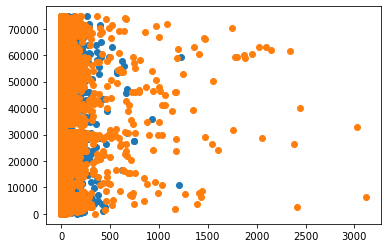

In [28]:
#table['predictions'] = predictions
plt.scatter(predictions,test_y.index)
plt.scatter(test_y,test_y.index)


In [29]:
learning_rate_list = [0.01, 0.05, 0.1]
max_depth_list = [3,4,5]
n_estimators_list = [500,1000, 1500]
subsample_list = [0.5, 0.8, 1.0]
colsample_bytree_list = [ 0.5,0.8, 1.0]

params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list,
              'subsample':subsample_list,
              'colsample_bytree':colsample_bytree_list}


In [30]:
num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

243


{'learning_rate': [0.01, 0.05, 0.1],
 'max_depth': [3, 4, 5],
 'n_estimators': [500, 1000, 1500],
 'subsample': [0.5, 0.8, 1.0],
 'colsample_bytree': [0.5, 0.8, 1.0]}

In [31]:
model_xgboost_hp = GridSearchCV(estimator=xgboost.XGBRegressor(eval_metric='mae',
                                                                use_label_encoder=False),
                                param_grid=params_dict,
                                cv=2,
                                scoring='neg_mean_absolute_error',
                                return_train_score=True,
                                verbose=False)

model_xgboost_hp.fit( train_X, train_y,early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)])

[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.14804
[2]	validation_0-mae:15.13655
[3]	validation_0-mae:15.14390
[4]	validation_0-mae:15.13331
[5]	validation_0-mae:15.14042
[6]	validation_0-mae:15.19157
[7]	validation_0-mae:15.19517
[8]	validation_0-mae:15.19631
[9]	validation_0-mae:15.21662
[0]	validation_0-mae:15.14601
[1]	validation_0-mae:15.17269
[2]	validation_0-mae:15.16367
[3]	validation_0-mae:15.20365


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.21625
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.14809
[2]	validation_0-mae:15.12910
[3]	validation_0-mae:15.13638
[4]	validation_0-mae:15.12488
[5]	validation_0-mae:15.13370
[6]	validation_0-mae:15.18418
[7]	validation_0-mae:15.18196
[8]	validation_0-mae:15.17572
[9]	validation_0-mae:15.19850
[0]	validation_0-mae:15.13647
[1]	validation_0-mae:15.16704
[2]	validation_0-mae:15.15622
[3]	validation_0-mae:15.20130


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.21186
[5]	validation_0-mae:15.21037
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.17598
[2]	validation_0-mae:15.15644
[3]	validation_0-mae:15.16020
[4]	validation_0-mae:15.14913
[5]	validation_0-mae:15.14412
[0]	validation_0-mae:15.13543
[1]	validation_0-mae:15.17362
[2]	validation_0-mae:15.15766
[3]	validation_0-mae:15.16275
[4]	validation_0-mae:15.15981


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.14804
[2]	validation_0-mae:15.13655
[3]	validation_0-mae:15.14390
[4]	validation_0-mae:15.13331
[5]	validation_0-mae:15.14042
[6]	validation_0-mae:15.19157
[7]	validation_0-mae:15.19517
[8]	validation_0-mae:15.19631
[9]	validation_0-mae:15.21662
[0]	validation_0-mae:15.14601
[1]	validation_0-mae:15.17269
[2]	validation_0-mae:15.16367
[3]	validation_0-mae:15.20365
[4]	validation_0-mae:15.21625
[5]	validation_0-mae:15.21658


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.14809
[2]	validation_0-mae:15.12910
[3]	validation_0-mae:15.13638
[4]	validation_0-mae:15.12488
[5]	validation_0-mae:15.13370
[6]	validation_0-mae:15.18418
[7]	validation_0-mae:15.18196
[8]	validation_0-mae:15.17572
[0]	validation_0-mae:15.13647
[1]	validation_0-mae:15.16704
[2]	validation_0-mae:15.15622


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.20130
[4]	validation_0-mae:15.21186
[5]	validation_0-mae:15.21037
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.17598
[2]	validation_0-mae:15.15644
[3]	validation_0-mae:15.16020
[4]	validation_0-mae:15.14913
[0]	validation_0-mae:15.13543
[1]	validation_0-mae:15.17362
[2]	validation_0-mae:15.15766
[3]	validation_0-mae:15.16275
[4]	validation_0-mae:15.15981
[5]	validation_0-mae:15.15584


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.14804
[2]	validation_0-mae:15.13655
[3]	validation_0-mae:15.14390
[4]	validation_0-mae:15.13331
[5]	validation_0-mae:15.14042
[6]	validation_0-mae:15.19157
[7]	validation_0-mae:15.19517
[8]	validation_0-mae:15.19631
[9]	validation_0-mae:15.21662
[0]	validation_0-mae:15.14601
[1]	validation_0-mae:15.17269
[2]	validation_0-mae:15.16367
[3]	validation_0-mae:15.20365
[4]	validation_0-mae:15.21625
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.14809
[2]	validation_0-mae:15.12910
[3]	validation_0-mae:15.13638
[4]	validation_0-mae:15.12488
[5]	validation_0-mae:15.13370
[6]	validation_0-mae:15.18418


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:15.18196
[8]	validation_0-mae:15.17572
[0]	validation_0-mae:15.13647
[1]	validation_0-mae:15.16704
[2]	validation_0-mae:15.15622
[3]	validation_0-mae:15.20130
[4]	validation_0-mae:15.21186
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.17598
[2]	validation_0-mae:15.15644
[3]	validation_0-mae:15.16020
[4]	validation_0-mae:15.14913


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13543
[1]	validation_0-mae:15.17362
[2]	validation_0-mae:15.15766
[3]	validation_0-mae:15.16275
[4]	validation_0-mae:15.15981
[5]	validation_0-mae:15.15584
[0]	validation_0-mae:15.12933
[1]	validation_0-mae:15.14214
[2]	validation_0-mae:15.12268
[3]	validation_0-mae:15.12692
[4]	validation_0-mae:15.11969
[5]	validation_0-mae:15.12628
[6]	validation_0-mae:15.17297
[7]	validation_0-mae:15.17126
[8]	validation_0-mae:15.17188


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.14003
[1]	validation_0-mae:15.16500
[2]	validation_0-mae:15.14568
[3]	validation_0-mae:15.18663
[4]	validation_0-mae:15.20211
[5]	validation_0-mae:15.19808
[0]	validation_0-mae:15.13658
[1]	validation_0-mae:15.14722
[2]	validation_0-mae:15.12309
[3]	validation_0-mae:15.12976
[4]	validation_0-mae:15.11644
[5]	validation_0-mae:15.12308
[6]	validation_0-mae:15.16929
[7]	validation_0-mae:15.16219


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:15.15909
[9]	validation_0-mae:15.18147
[0]	validation_0-mae:15.13176
[1]	validation_0-mae:15.15989
[2]	validation_0-mae:15.14035
[3]	validation_0-mae:15.17830
[4]	validation_0-mae:15.19158
[0]	validation_0-mae:15.13465
[1]	validation_0-mae:15.17126
[2]	validation_0-mae:15.15358
[3]	validation_0-mae:15.15911
[4]	validation_0-mae:15.15082
[5]	validation_0-mae:15.14371


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12808
[1]	validation_0-mae:15.16575
[2]	validation_0-mae:15.14533
[3]	validation_0-mae:15.14778
[4]	validation_0-mae:15.13788
[0]	validation_0-mae:15.12933
[1]	validation_0-mae:15.14214
[2]	validation_0-mae:15.12268
[3]	validation_0-mae:15.12692
[4]	validation_0-mae:15.11969
[5]	validation_0-mae:15.12628


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:15.17297
[7]	validation_0-mae:15.17126
[8]	validation_0-mae:15.17188
[0]	validation_0-mae:15.14003
[1]	validation_0-mae:15.16500
[2]	validation_0-mae:15.14568
[3]	validation_0-mae:15.18663
[4]	validation_0-mae:15.20211
[0]	validation_0-mae:15.13658
[1]	validation_0-mae:15.14722
[2]	validation_0-mae:15.12309
[3]	validation_0-mae:15.12976
[4]	validation_0-mae:15.11644
[5]	validation_0-mae:15.12308
[6]	validation_0-mae:15.16929
[7]	validation_0-mae:15.16219
[8]	validation_0-mae:15.15909


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13176
[1]	validation_0-mae:15.15989
[2]	validation_0-mae:15.14035
[3]	validation_0-mae:15.17830
[4]	validation_0-mae:15.19158
[0]	validation_0-mae:15.13465
[1]	validation_0-mae:15.17126
[2]	validation_0-mae:15.15358
[3]	validation_0-mae:15.15911
[4]	validation_0-mae:15.15082


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12808
[1]	validation_0-mae:15.16575
[2]	validation_0-mae:15.14533
[3]	validation_0-mae:15.14778
[4]	validation_0-mae:15.13788
[5]	validation_0-mae:15.13024
[0]	validation_0-mae:15.12933
[1]	validation_0-mae:15.14214
[2]	validation_0-mae:15.12268
[3]	validation_0-mae:15.12692
[4]	validation_0-mae:15.11969
[5]	validation_0-mae:15.12628
[6]	validation_0-mae:15.17297
[7]	validation_0-mae:15.17126
[8]	validation_0-mae:15.17188


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.14003
[1]	validation_0-mae:15.16500
[2]	validation_0-mae:15.14568
[3]	validation_0-mae:15.18663
[4]	validation_0-mae:15.20211
[5]	validation_0-mae:15.19808
[0]	validation_0-mae:15.13658
[1]	validation_0-mae:15.14722
[2]	validation_0-mae:15.12309
[3]	validation_0-mae:15.12976
[4]	validation_0-mae:15.11644
[5]	validation_0-mae:15.12308
[6]	validation_0-mae:15.16929
[7]	validation_0-mae:15.16219


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:15.15909
[9]	validation_0-mae:15.18147
[0]	validation_0-mae:15.13176
[1]	validation_0-mae:15.15989
[2]	validation_0-mae:15.14035
[3]	validation_0-mae:15.17830
[4]	validation_0-mae:15.19158
[0]	validation_0-mae:15.13465
[1]	validation_0-mae:15.17126
[2]	validation_0-mae:15.15358
[3]	validation_0-mae:15.15911
[4]	validation_0-mae:15.15082


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12808
[1]	validation_0-mae:15.16575
[2]	validation_0-mae:15.14533
[3]	validation_0-mae:15.14778
[4]	validation_0-mae:15.13788
[5]	validation_0-mae:15.13024
[0]	validation_0-mae:15.12936
[1]	validation_0-mae:15.14238
[2]	validation_0-mae:15.12049
[3]	validation_0-mae:15.12226
[4]	validation_0-mae:15.11351
[5]	validation_0-mae:15.12490
[6]	validation_0-mae:15.17330
[7]	validation_0-mae:15.17107


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:15.17200
[0]	validation_0-mae:15.13451
[1]	validation_0-mae:15.16222
[2]	validation_0-mae:15.14312
[3]	validation_0-mae:15.18786
[4]	validation_0-mae:15.20135
[0]	validation_0-mae:15.13798
[1]	validation_0-mae:15.14611
[2]	validation_0-mae:15.12123
[3]	validation_0-mae:15.12477
[4]	validation_0-mae:15.11575


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.12335
[6]	validation_0-mae:15.16692
[7]	validation_0-mae:15.16184
[8]	validation_0-mae:15.16178
[0]	validation_0-mae:15.12465
[1]	validation_0-mae:15.15062
[2]	validation_0-mae:15.13239
[3]	validation_0-mae:15.17254
[4]	validation_0-mae:15.18502
[5]	validation_0-mae:15.17185
[0]	validation_0-mae:15.13252
[1]	validation_0-mae:15.16656
[2]	validation_0-mae:15.15095
[3]	validation_0-mae:15.14854
[4]	validation_0-mae:15.14081


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12452
[1]	validation_0-mae:15.16196
[2]	validation_0-mae:15.14351
[3]	validation_0-mae:15.14409
[4]	validation_0-mae:15.13738
[0]	validation_0-mae:15.12936
[1]	validation_0-mae:15.14238
[2]	validation_0-mae:15.12049
[3]	validation_0-mae:15.12226
[4]	validation_0-mae:15.11351
[5]	validation_0-mae:15.12490


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:15.17330
[7]	validation_0-mae:15.17107
[8]	validation_0-mae:15.17200
[0]	validation_0-mae:15.13451
[1]	validation_0-mae:15.16222
[2]	validation_0-mae:15.14312
[3]	validation_0-mae:15.18786
[4]	validation_0-mae:15.20135
[5]	validation_0-mae:15.19306
[0]	validation_0-mae:15.13798
[1]	validation_0-mae:15.14611
[2]	validation_0-mae:15.12123
[3]	validation_0-mae:15.12477
[4]	validation_0-mae:15.11575
[5]	validation_0-mae:15.12335


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:15.16692
[7]	validation_0-mae:15.16184
[8]	validation_0-mae:15.16178
[0]	validation_0-mae:15.12465
[1]	validation_0-mae:15.15062
[2]	validation_0-mae:15.13239
[3]	validation_0-mae:15.17254
[4]	validation_0-mae:15.18502
[0]	validation_0-mae:15.13252
[1]	validation_0-mae:15.16656
[2]	validation_0-mae:15.15095
[3]	validation_0-mae:15.14854
[4]	validation_0-mae:15.14081


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12452
[1]	validation_0-mae:15.16196
[2]	validation_0-mae:15.14351
[3]	validation_0-mae:15.14409
[4]	validation_0-mae:15.13738
[5]	validation_0-mae:15.12530
[0]	validation_0-mae:15.12936
[1]	validation_0-mae:15.14238
[2]	validation_0-mae:15.12049
[3]	validation_0-mae:15.12226
[4]	validation_0-mae:15.11351
[5]	validation_0-mae:15.12490
[6]	validation_0-mae:15.17330


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:15.17107
[8]	validation_0-mae:15.17200
[0]	validation_0-mae:15.13451
[1]	validation_0-mae:15.16222
[2]	validation_0-mae:15.14312
[3]	validation_0-mae:15.18786
[4]	validation_0-mae:15.20135
[0]	validation_0-mae:15.13798
[1]	validation_0-mae:15.14611
[2]	validation_0-mae:15.12123
[3]	validation_0-mae:15.12477
[4]	validation_0-mae:15.11575
[5]	validation_0-mae:15.12335
[6]	validation_0-mae:15.16692
[7]	validation_0-mae:15.16184


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:15.16178
[9]	validation_0-mae:15.18076
[0]	validation_0-mae:15.12465
[1]	validation_0-mae:15.15062
[2]	validation_0-mae:15.13239
[3]	validation_0-mae:15.17254
[4]	validation_0-mae:15.18502
[0]	validation_0-mae:15.13252
[1]	validation_0-mae:15.16656
[2]	validation_0-mae:15.15095
[3]	validation_0-mae:15.14854
[4]	validation_0-mae:15.14081


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12452
[1]	validation_0-mae:15.16196
[2]	validation_0-mae:15.14351
[3]	validation_0-mae:15.14409
[4]	validation_0-mae:15.13738
[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.22560
[2]	validation_0-mae:15.24560
[3]	validation_0-mae:15.37831
[4]	validation_0-mae:15.44325
[5]	validation_0-mae:15.60298


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12659
[1]	validation_0-mae:15.35380
[2]	validation_0-mae:15.40178
[3]	validation_0-mae:15.71016
[4]	validation_0-mae:15.85809
[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.22179
[2]	validation_0-mae:15.21666
[3]	validation_0-mae:15.35398
[4]	validation_0-mae:15.38443


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10286
[1]	validation_0-mae:15.34517
[2]	validation_0-mae:15.39377
[3]	validation_0-mae:15.70721
[4]	validation_0-mae:15.84175
[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.36424
[2]	validation_0-mae:15.36790
[3]	validation_0-mae:15.47150
[4]	validation_0-mae:15.53181
[5]	validation_0-mae:15.58524


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09886
[1]	validation_0-mae:15.36885
[2]	validation_0-mae:15.40089
[3]	validation_0-mae:15.51435
[4]	validation_0-mae:15.62365
[5]	validation_0-mae:15.70485
[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.22560
[2]	validation_0-mae:15.24560
[3]	validation_0-mae:15.37831
[4]	validation_0-mae:15.44325
[5]	validation_0-mae:15.60298


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12659
[1]	validation_0-mae:15.35380
[2]	validation_0-mae:15.40178
[3]	validation_0-mae:15.71016
[4]	validation_0-mae:15.85809
[5]	validation_0-mae:15.95965
[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.22179
[2]	validation_0-mae:15.21666
[3]	validation_0-mae:15.35398
[4]	validation_0-mae:15.38443
[5]	validation_0-mae:15.53357


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10286
[1]	validation_0-mae:15.34517
[2]	validation_0-mae:15.39377
[3]	validation_0-mae:15.70721
[4]	validation_0-mae:15.84175
[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.36424
[2]	validation_0-mae:15.36790
[3]	validation_0-mae:15.47150
[4]	validation_0-mae:15.53181


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09886
[1]	validation_0-mae:15.36885
[2]	validation_0-mae:15.40089
[3]	validation_0-mae:15.51435
[4]	validation_0-mae:15.62365
[5]	validation_0-mae:15.70485
[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.22560
[2]	validation_0-mae:15.24560
[3]	validation_0-mae:15.37831
[4]	validation_0-mae:15.44325


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12659
[1]	validation_0-mae:15.35380
[2]	validation_0-mae:15.40178
[3]	validation_0-mae:15.71016
[4]	validation_0-mae:15.85809
[5]	validation_0-mae:15.95965
[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.22179
[2]	validation_0-mae:15.21666
[3]	validation_0-mae:15.35398
[4]	validation_0-mae:15.38443


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10286
[1]	validation_0-mae:15.34517
[2]	validation_0-mae:15.39377
[3]	validation_0-mae:15.70721
[4]	validation_0-mae:15.84175
[5]	validation_0-mae:15.93857
[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.36424
[2]	validation_0-mae:15.36790
[3]	validation_0-mae:15.47150
[4]	validation_0-mae:15.53181
[5]	validation_0-mae:15.58524


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09886
[1]	validation_0-mae:15.36885
[2]	validation_0-mae:15.40089
[3]	validation_0-mae:15.51435
[4]	validation_0-mae:15.62365
[0]	validation_0-mae:15.06840
[1]	validation_0-mae:15.20159
[2]	validation_0-mae:15.20362
[3]	validation_0-mae:15.32688
[4]	validation_0-mae:15.39177
[5]	validation_0-mae:15.54768


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11159
[1]	validation_0-mae:15.32633
[2]	validation_0-mae:15.33006
[3]	validation_0-mae:15.64692
[4]	validation_0-mae:15.80053
[0]	validation_0-mae:15.10030
[1]	validation_0-mae:15.22879
[2]	validation_0-mae:15.19579
[3]	validation_0-mae:15.33078
[4]	validation_0-mae:15.35736


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07539
[1]	validation_0-mae:15.31252
[2]	validation_0-mae:15.33032
[3]	validation_0-mae:15.62165
[4]	validation_0-mae:15.77220
[5]	validation_0-mae:15.86414
[0]	validation_0-mae:15.09541
[1]	validation_0-mae:15.35910
[2]	validation_0-mae:15.37291
[3]	validation_0-mae:15.47706
[4]	validation_0-mae:15.55241


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.05712
[1]	validation_0-mae:15.32600
[2]	validation_0-mae:15.35924
[3]	validation_0-mae:15.46250
[4]	validation_0-mae:15.54352
[0]	validation_0-mae:15.06840
[1]	validation_0-mae:15.20159
[2]	validation_0-mae:15.20362
[3]	validation_0-mae:15.32688
[4]	validation_0-mae:15.39177


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11159
[1]	validation_0-mae:15.32633
[2]	validation_0-mae:15.33006
[3]	validation_0-mae:15.64692
[4]	validation_0-mae:15.80053
[5]	validation_0-mae:15.87522
[0]	validation_0-mae:15.10030
[1]	validation_0-mae:15.22879
[2]	validation_0-mae:15.19579
[3]	validation_0-mae:15.33078
[4]	validation_0-mae:15.35736


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07539
[1]	validation_0-mae:15.31252
[2]	validation_0-mae:15.33032
[3]	validation_0-mae:15.62165
[4]	validation_0-mae:15.77220
[0]	validation_0-mae:15.09541
[1]	validation_0-mae:15.35910
[2]	validation_0-mae:15.37291
[3]	validation_0-mae:15.47706
[4]	validation_0-mae:15.55241


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.05712
[1]	validation_0-mae:15.32600
[2]	validation_0-mae:15.35924
[3]	validation_0-mae:15.46250
[4]	validation_0-mae:15.54352
[5]	validation_0-mae:15.61730
[0]	validation_0-mae:15.06840
[1]	validation_0-mae:15.20159
[2]	validation_0-mae:15.20362
[3]	validation_0-mae:15.32688
[4]	validation_0-mae:15.39177


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11159
[1]	validation_0-mae:15.32633
[2]	validation_0-mae:15.33006
[3]	validation_0-mae:15.64692
[4]	validation_0-mae:15.80053
[0]	validation_0-mae:15.10030
[1]	validation_0-mae:15.22879
[2]	validation_0-mae:15.19579
[3]	validation_0-mae:15.33078
[4]	validation_0-mae:15.35736


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07539
[1]	validation_0-mae:15.31252
[2]	validation_0-mae:15.33032
[3]	validation_0-mae:15.62165
[4]	validation_0-mae:15.77220
[5]	validation_0-mae:15.86414
[0]	validation_0-mae:15.09541
[1]	validation_0-mae:15.35910
[2]	validation_0-mae:15.37291
[3]	validation_0-mae:15.47706
[4]	validation_0-mae:15.55241


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.05712
[1]	validation_0-mae:15.32600
[2]	validation_0-mae:15.35924
[3]	validation_0-mae:15.46250
[4]	validation_0-mae:15.54352
[0]	validation_0-mae:15.06756
[1]	validation_0-mae:15.20865
[2]	validation_0-mae:15.20415
[3]	validation_0-mae:15.33930
[4]	validation_0-mae:15.41711
[5]	validation_0-mae:15.58550


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08796
[1]	validation_0-mae:15.31637
[2]	validation_0-mae:15.32815
[3]	validation_0-mae:15.64802
[4]	validation_0-mae:15.79857
[0]	validation_0-mae:15.11060
[1]	validation_0-mae:15.21827
[2]	validation_0-mae:15.24851
[3]	validation_0-mae:15.35651
[4]	validation_0-mae:15.39170


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04195
[1]	validation_0-mae:15.27570
[2]	validation_0-mae:15.30090
[3]	validation_0-mae:15.59770
[4]	validation_0-mae:15.76010
[5]	validation_0-mae:15.82054
[0]	validation_0-mae:15.08620
[1]	validation_0-mae:15.34072
[2]	validation_0-mae:15.35442
[3]	validation_0-mae:15.42279
[4]	validation_0-mae:15.49775
[5]	validation_0-mae:15.56147


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04449
[1]	validation_0-mae:15.31360
[2]	validation_0-mae:15.34975
[3]	validation_0-mae:15.45375
[4]	validation_0-mae:15.53838
[5]	validation_0-mae:15.59444
[0]	validation_0-mae:15.06756
[1]	validation_0-mae:15.20865
[2]	validation_0-mae:15.20415
[3]	validation_0-mae:15.33930
[4]	validation_0-mae:15.41711


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08796
[1]	validation_0-mae:15.31637
[2]	validation_0-mae:15.32815
[3]	validation_0-mae:15.64802
[4]	validation_0-mae:15.79857
[5]	validation_0-mae:15.86633
[0]	validation_0-mae:15.11060
[1]	validation_0-mae:15.21827
[2]	validation_0-mae:15.24851
[3]	validation_0-mae:15.35651
[4]	validation_0-mae:15.39170
[5]	validation_0-mae:15.52888


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04195
[1]	validation_0-mae:15.27570
[2]	validation_0-mae:15.30090
[3]	validation_0-mae:15.59770
[4]	validation_0-mae:15.76010
[0]	validation_0-mae:15.08620
[1]	validation_0-mae:15.34072
[2]	validation_0-mae:15.35442
[3]	validation_0-mae:15.42279
[4]	validation_0-mae:15.49775
[5]	validation_0-mae:15.56147


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04449
[1]	validation_0-mae:15.31360
[2]	validation_0-mae:15.34975
[3]	validation_0-mae:15.45375
[4]	validation_0-mae:15.53838
[5]	validation_0-mae:15.59444
[0]	validation_0-mae:15.06756
[1]	validation_0-mae:15.20865
[2]	validation_0-mae:15.20415
[3]	validation_0-mae:15.33930
[4]	validation_0-mae:15.41711


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08796
[1]	validation_0-mae:15.31637
[2]	validation_0-mae:15.32815
[3]	validation_0-mae:15.64802
[4]	validation_0-mae:15.79857
[5]	validation_0-mae:15.86633
[0]	validation_0-mae:15.11060
[1]	validation_0-mae:15.21827
[2]	validation_0-mae:15.24851
[3]	validation_0-mae:15.35651
[4]	validation_0-mae:15.39170
[5]	validation_0-mae:15.52888


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04195
[1]	validation_0-mae:15.27570
[2]	validation_0-mae:15.30090
[3]	validation_0-mae:15.59770
[4]	validation_0-mae:15.76010
[5]	validation_0-mae:15.82054
[0]	validation_0-mae:15.08620
[1]	validation_0-mae:15.34072
[2]	validation_0-mae:15.35442
[3]	validation_0-mae:15.42279
[4]	validation_0-mae:15.49775


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04449
[1]	validation_0-mae:15.31360
[2]	validation_0-mae:15.34975
[3]	validation_0-mae:15.45375
[4]	validation_0-mae:15.53838
[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.46326
[2]	validation_0-mae:15.62903
[3]	validation_0-mae:15.95024
[4]	validation_0-mae:16.17521
[5]	validation_0-mae:16.54042


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.16686
[1]	validation_0-mae:15.70931
[2]	validation_0-mae:15.88143
[3]	validation_0-mae:16.51054
[4]	validation_0-mae:16.84105
[5]	validation_0-mae:17.13716
[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.41866
[2]	validation_0-mae:15.53269
[3]	validation_0-mae:15.88862
[4]	validation_0-mae:16.06027


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.14017
[1]	validation_0-mae:15.71583
[2]	validation_0-mae:15.90587
[3]	validation_0-mae:16.52258
[4]	validation_0-mae:16.86115
[5]	validation_0-mae:17.06992
[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.70677
[2]	validation_0-mae:15.80432
[3]	validation_0-mae:16.03039
[4]	validation_0-mae:16.23897


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13424
[1]	validation_0-mae:15.74870
[2]	validation_0-mae:15.91265
[3]	validation_0-mae:16.20798
[4]	validation_0-mae:16.47414
[5]	validation_0-mae:16.71202
[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.46326
[2]	validation_0-mae:15.62903
[3]	validation_0-mae:15.95024
[4]	validation_0-mae:16.17521
[5]	validation_0-mae:16.54042


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.16686
[1]	validation_0-mae:15.70931
[2]	validation_0-mae:15.88143
[3]	validation_0-mae:16.51054
[4]	validation_0-mae:16.84105
[5]	validation_0-mae:17.13716
[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.41866
[2]	validation_0-mae:15.53269
[3]	validation_0-mae:15.88862
[4]	validation_0-mae:16.06027


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.14017
[1]	validation_0-mae:15.71583
[2]	validation_0-mae:15.90587
[3]	validation_0-mae:16.52258
[4]	validation_0-mae:16.86115
[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.70677
[2]	validation_0-mae:15.80432
[3]	validation_0-mae:16.03039
[4]	validation_0-mae:16.23897
[5]	validation_0-mae:16.45434


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13424
[1]	validation_0-mae:15.74870
[2]	validation_0-mae:15.91265
[3]	validation_0-mae:16.20798
[4]	validation_0-mae:16.47414
[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.46326
[2]	validation_0-mae:15.62903
[3]	validation_0-mae:15.95024
[4]	validation_0-mae:16.17521


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.16686
[1]	validation_0-mae:15.70931
[2]	validation_0-mae:15.88143
[3]	validation_0-mae:16.51054
[4]	validation_0-mae:16.84105
[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.41866
[2]	validation_0-mae:15.53269
[3]	validation_0-mae:15.88862


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:16.06027
[5]	validation_0-mae:16.42053
[0]	validation_0-mae:15.14017
[1]	validation_0-mae:15.71583
[2]	validation_0-mae:15.90587
[3]	validation_0-mae:16.52258
[4]	validation_0-mae:16.86115
[5]	validation_0-mae:17.06992
[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.70677
[2]	validation_0-mae:15.80432
[3]	validation_0-mae:16.03039
[4]	validation_0-mae:16.23897


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13424
[1]	validation_0-mae:15.74870
[2]	validation_0-mae:15.91265
[3]	validation_0-mae:16.20798
[4]	validation_0-mae:16.47414
[0]	validation_0-mae:15.05774
[1]	validation_0-mae:15.43264
[2]	validation_0-mae:15.50062
[3]	validation_0-mae:15.82474
[4]	validation_0-mae:16.03845
[5]	validation_0-mae:16.38807


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13124
[1]	validation_0-mae:15.68048
[2]	validation_0-mae:15.77378
[3]	validation_0-mae:16.42812
[4]	validation_0-mae:16.75616
[0]	validation_0-mae:15.12338
[1]	validation_0-mae:15.44466
[2]	validation_0-mae:15.50095
[3]	validation_0-mae:15.85766
[4]	validation_0-mae:16.01504


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09001
[1]	validation_0-mae:15.65804
[2]	validation_0-mae:15.80549
[3]	validation_0-mae:16.40039
[4]	validation_0-mae:16.72209
[0]	validation_0-mae:15.10294
[1]	validation_0-mae:15.70839
[2]	validation_0-mae:15.82070
[3]	validation_0-mae:16.04621
[4]	validation_0-mae:16.27123
[5]	validation_0-mae:16.47731


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04909
[1]	validation_0-mae:15.66289
[2]	validation_0-mae:15.82286
[3]	validation_0-mae:16.10115
[4]	validation_0-mae:16.36284
[0]	validation_0-mae:15.05774
[1]	validation_0-mae:15.43264
[2]	validation_0-mae:15.50062
[3]	validation_0-mae:15.82474
[4]	validation_0-mae:16.03845


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13124
[1]	validation_0-mae:15.68048
[2]	validation_0-mae:15.77378
[3]	validation_0-mae:16.42812
[4]	validation_0-mae:16.75616
[5]	validation_0-mae:16.96032
[0]	validation_0-mae:15.12338
[1]	validation_0-mae:15.44466
[2]	validation_0-mae:15.50095
[3]	validation_0-mae:15.85766
[4]	validation_0-mae:16.01504


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09001
[1]	validation_0-mae:15.65804
[2]	validation_0-mae:15.80549
[3]	validation_0-mae:16.40039
[4]	validation_0-mae:16.72209
[5]	validation_0-mae:16.92451
[0]	validation_0-mae:15.10294
[1]	validation_0-mae:15.70839
[2]	validation_0-mae:15.82070
[3]	validation_0-mae:16.04621
[4]	validation_0-mae:16.27123


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04909
[1]	validation_0-mae:15.66289
[2]	validation_0-mae:15.82286
[3]	validation_0-mae:16.10115
[4]	validation_0-mae:16.36284
[0]	validation_0-mae:15.05774
[1]	validation_0-mae:15.43264
[2]	validation_0-mae:15.50062
[3]	validation_0-mae:15.82474
[4]	validation_0-mae:16.03845
[5]	validation_0-mae:16.38807


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13124
[1]	validation_0-mae:15.68048
[2]	validation_0-mae:15.77378
[3]	validation_0-mae:16.42812
[4]	validation_0-mae:16.75616
[5]	validation_0-mae:16.96032
[0]	validation_0-mae:15.12338
[1]	validation_0-mae:15.44466
[2]	validation_0-mae:15.50095
[3]	validation_0-mae:15.85766
[4]	validation_0-mae:16.01504


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09001
[1]	validation_0-mae:15.65804
[2]	validation_0-mae:15.80549
[3]	validation_0-mae:16.40039
[4]	validation_0-mae:16.72209
[5]	validation_0-mae:16.92451
[0]	validation_0-mae:15.10294
[1]	validation_0-mae:15.70839
[2]	validation_0-mae:15.82070
[3]	validation_0-mae:16.04621
[4]	validation_0-mae:16.27123


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.04909
[1]	validation_0-mae:15.66289
[2]	validation_0-mae:15.82286
[3]	validation_0-mae:16.10115
[4]	validation_0-mae:16.36284
[5]	validation_0-mae:16.59583
[0]	validation_0-mae:15.06395
[1]	validation_0-mae:15.44423
[2]	validation_0-mae:15.52421
[3]	validation_0-mae:15.83287
[4]	validation_0-mae:16.06136
[5]	validation_0-mae:16.48267


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09431
[1]	validation_0-mae:15.66538
[2]	validation_0-mae:15.78944
[3]	validation_0-mae:16.43281
[4]	validation_0-mae:16.74951
[5]	validation_0-mae:16.94600
[0]	validation_0-mae:15.14267
[1]	validation_0-mae:15.44114
[2]	validation_0-mae:15.59665
[3]	validation_0-mae:15.89139
[4]	validation_0-mae:16.07944


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.01809
[1]	validation_0-mae:15.59362
[2]	validation_0-mae:15.76255
[3]	validation_0-mae:16.36771
[4]	validation_0-mae:16.72629
[5]	validation_0-mae:16.91937
[0]	validation_0-mae:15.09014
[1]	validation_0-mae:15.68383
[2]	validation_0-mae:15.79920
[3]	validation_0-mae:15.98787
[4]	validation_0-mae:16.21079


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.02031
[1]	validation_0-mae:15.64524
[2]	validation_0-mae:15.80219
[3]	validation_0-mae:16.08759
[4]	validation_0-mae:16.36301
[5]	validation_0-mae:16.59066
[0]	validation_0-mae:15.06395
[1]	validation_0-mae:15.44423
[2]	validation_0-mae:15.52421
[3]	validation_0-mae:15.83287
[4]	validation_0-mae:16.06136


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09431
[1]	validation_0-mae:15.66538
[2]	validation_0-mae:15.78944
[3]	validation_0-mae:16.43281
[4]	validation_0-mae:16.74951
[0]	validation_0-mae:15.14267
[1]	validation_0-mae:15.44114
[2]	validation_0-mae:15.59665
[3]	validation_0-mae:15.89139
[4]	validation_0-mae:16.07944


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:16.38770
[0]	validation_0-mae:15.01809
[1]	validation_0-mae:15.59362
[2]	validation_0-mae:15.76255
[3]	validation_0-mae:16.36771
[4]	validation_0-mae:16.72629
[5]	validation_0-mae:16.91937
[0]	validation_0-mae:15.09014
[1]	validation_0-mae:15.68383
[2]	validation_0-mae:15.79920
[3]	validation_0-mae:15.98787
[4]	validation_0-mae:16.21079
[5]	validation_0-mae:16.41491


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.02031
[1]	validation_0-mae:15.64524
[2]	validation_0-mae:15.80219
[3]	validation_0-mae:16.08759
[4]	validation_0-mae:16.36301
[5]	validation_0-mae:16.59066
[0]	validation_0-mae:15.06395
[1]	validation_0-mae:15.44423
[2]	validation_0-mae:15.52421
[3]	validation_0-mae:15.83287
[4]	validation_0-mae:16.06136
[5]	validation_0-mae:16.48267


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09431
[1]	validation_0-mae:15.66538
[2]	validation_0-mae:15.78944
[3]	validation_0-mae:16.43281
[4]	validation_0-mae:16.74951
[0]	validation_0-mae:15.14267
[1]	validation_0-mae:15.44114
[2]	validation_0-mae:15.59665
[3]	validation_0-mae:15.89139
[4]	validation_0-mae:16.07944
[5]	validation_0-mae:16.38770


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.01809
[1]	validation_0-mae:15.59362
[2]	validation_0-mae:15.76255
[3]	validation_0-mae:16.36771
[4]	validation_0-mae:16.72629
[5]	validation_0-mae:16.91937
[0]	validation_0-mae:15.09014
[1]	validation_0-mae:15.68383
[2]	validation_0-mae:15.79920
[3]	validation_0-mae:15.98787
[4]	validation_0-mae:16.21079
[5]	validation_0-mae:16.41491


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.02031
[1]	validation_0-mae:15.64524
[2]	validation_0-mae:15.80219
[3]	validation_0-mae:16.08759
[4]	validation_0-mae:16.36301
[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.13532
[2]	validation_0-mae:15.12464
[3]	validation_0-mae:15.11980
[4]	validation_0-mae:15.10987
[5]	validation_0-mae:15.11492


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:15.11282
[7]	validation_0-mae:15.11746
[8]	validation_0-mae:15.11951
[0]	validation_0-mae:15.14308
[1]	validation_0-mae:15.17519
[2]	validation_0-mae:15.16612
[3]	validation_0-mae:15.20831
[4]	validation_0-mae:15.19627
[5]	validation_0-mae:15.19633
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.13082
[2]	validation_0-mae:15.11209
[3]	validation_0-mae:15.09856
[4]	validation_0-mae:15.08766
[5]	validation_0-mae:15.10193
[6]	validation_0-mae:15.10649
[7]	validation_0-mae:15.10804


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:15.10275
[9]	validation_0-mae:15.10231
[0]	validation_0-mae:15.13654
[1]	validation_0-mae:15.17119
[2]	validation_0-mae:15.16000
[3]	validation_0-mae:15.20439
[4]	validation_0-mae:15.19774
[5]	validation_0-mae:15.19207
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.12000
[2]	validation_0-mae:15.10729
[3]	validation_0-mae:15.11115
[4]	validation_0-mae:15.09994
[5]	validation_0-mae:15.09755
[6]	validation_0-mae:15.11242
[7]	validation_0-mae:15.10963
[8]	validation_0-mae:15.11089
[9]	validation_0-mae:15.11118


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13555
[1]	validation_0-mae:15.12131
[2]	validation_0-mae:15.10958
[3]	validation_0-mae:15.11637
[4]	validation_0-mae:15.11540
[5]	validation_0-mae:15.11414
[6]	validation_0-mae:15.13097
[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.13532
[2]	validation_0-mae:15.12464
[3]	validation_0-mae:15.11980
[4]	validation_0-mae:15.10987
[5]	validation_0-mae:15.11492
[6]	validation_0-mae:15.11282
[7]	validation_0-mae:15.11746
[8]	validation_0-mae:15.11951


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:15.11402
[0]	validation_0-mae:15.14308
[1]	validation_0-mae:15.17519
[2]	validation_0-mae:15.16612
[3]	validation_0-mae:15.20831
[4]	validation_0-mae:15.19627
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.13082
[2]	validation_0-mae:15.11209
[3]	validation_0-mae:15.09856
[4]	validation_0-mae:15.08766
[5]	validation_0-mae:15.10193
[6]	validation_0-mae:15.10649
[7]	validation_0-mae:15.10804


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:15.10275
[0]	validation_0-mae:15.13654
[1]	validation_0-mae:15.17119
[2]	validation_0-mae:15.16000
[3]	validation_0-mae:15.20439
[4]	validation_0-mae:15.19774
[5]	validation_0-mae:15.19207
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.12000
[2]	validation_0-mae:15.10729
[3]	validation_0-mae:15.11115
[4]	validation_0-mae:15.09994
[5]	validation_0-mae:15.09755
[6]	validation_0-mae:15.11242
[7]	validation_0-mae:15.10963
[8]	validation_0-mae:15.11089
[9]	validation_0-mae:15.11118


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-mae:15.11090
[0]	validation_0-mae:15.13555
[1]	validation_0-mae:15.12131
[2]	validation_0-mae:15.10958
[3]	validation_0-mae:15.11637
[4]	validation_0-mae:15.11540
[5]	validation_0-mae:15.11414
[6]	validation_0-mae:15.13097
[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.13532
[2]	validation_0-mae:15.12464
[3]	validation_0-mae:15.11980
[4]	validation_0-mae:15.10987
[5]	validation_0-mae:15.11492


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:15.11282
[7]	validation_0-mae:15.11746
[8]	validation_0-mae:15.11951
[0]	validation_0-mae:15.14308
[1]	validation_0-mae:15.17519
[2]	validation_0-mae:15.16612
[3]	validation_0-mae:15.20831
[4]	validation_0-mae:15.19627
[5]	validation_0-mae:15.19633
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.13082
[2]	validation_0-mae:15.11209
[3]	validation_0-mae:15.09856
[4]	validation_0-mae:15.08766
[5]	validation_0-mae:15.10193
[6]	validation_0-mae:15.10649
[7]	validation_0-mae:15.10804
[8]	validation_0-mae:15.10275


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:15.10231
[0]	validation_0-mae:15.13654
[1]	validation_0-mae:15.17119
[2]	validation_0-mae:15.16000
[3]	validation_0-mae:15.20439
[4]	validation_0-mae:15.19774
[5]	validation_0-mae:15.19207
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.12000
[2]	validation_0-mae:15.10729
[3]	validation_0-mae:15.11115
[4]	validation_0-mae:15.09994
[5]	validation_0-mae:15.09755
[6]	validation_0-mae:15.11242
[7]	validation_0-mae:15.10963
[8]	validation_0-mae:15.11089
[9]	validation_0-mae:15.11118


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13555
[1]	validation_0-mae:15.12131
[2]	validation_0-mae:15.10958
[3]	validation_0-mae:15.11637
[4]	validation_0-mae:15.11540
[5]	validation_0-mae:15.11414
[6]	validation_0-mae:15.13097
[0]	validation_0-mae:15.12933
[1]	validation_0-mae:15.12880
[2]	validation_0-mae:15.10566
[3]	validation_0-mae:15.09576
[4]	validation_0-mae:15.09015
[5]	validation_0-mae:15.09198
[6]	validation_0-mae:15.09000


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:15.08623
[8]	validation_0-mae:15.08418
[9]	validation_0-mae:15.07693
[10]	validation_0-mae:15.08952
[11]	validation_0-mae:15.11141
[12]	validation_0-mae:15.10984
[13]	validation_0-mae:15.11435
[14]	validation_0-mae:15.12231
[0]	validation_0-mae:15.13188
[1]	validation_0-mae:15.16140
[2]	validation_0-mae:15.14264
[3]	validation_0-mae:15.18250
[4]	validation_0-mae:15.17083
[5]	validation_0-mae:15.16126
[0]	validation_0-mae:15.13615
[1]	validation_0-mae:15.13071
[2]	validation_0-mae:15.10803
[3]	validation_0-mae:15.09280
[4]	validation_0-mae:15.08147


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.08841
[6]	validation_0-mae:15.08668
[7]	validation_0-mae:15.08482
[8]	validation_0-mae:15.08185
[9]	validation_0-mae:15.08218
[0]	validation_0-mae:15.13195
[1]	validation_0-mae:15.16106
[2]	validation_0-mae:15.14139
[3]	validation_0-mae:15.18116
[4]	validation_0-mae:15.16907
[5]	validation_0-mae:15.16059
[0]	validation_0-mae:15.13230
[1]	validation_0-mae:15.11562
[2]	validation_0-mae:15.09995
[3]	validation_0-mae:15.10614
[4]	validation_0-mae:15.09941
[5]	validation_0-mae:15.09358
[6]	validation_0-mae:15.10544
[7]	validation_0-mae:15.10235
[8]	validation_0-mae:15.10376


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:15.09988
[10]	validation_0-mae:15.09973
[0]	validation_0-mae:15.13101
[1]	validation_0-mae:15.10938
[2]	validation_0-mae:15.09422
[3]	validation_0-mae:15.09481
[4]	validation_0-mae:15.08405
[5]	validation_0-mae:15.07902
[6]	validation_0-mae:15.09292
[7]	validation_0-mae:15.09273
[8]	validation_0-mae:15.09448
[9]	validation_0-mae:15.09438
[0]	validation_0-mae:15.12933
[1]	validation_0-mae:15.12880
[2]	validation_0-mae:15.10566


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.09576
[4]	validation_0-mae:15.09015
[5]	validation_0-mae:15.09198
[6]	validation_0-mae:15.09000
[7]	validation_0-mae:15.08623
[8]	validation_0-mae:15.08418
[9]	validation_0-mae:15.07693
[10]	validation_0-mae:15.08952
[11]	validation_0-mae:15.11141
[12]	validation_0-mae:15.10984
[13]	validation_0-mae:15.11435
[14]	validation_0-mae:15.12231
[0]	validation_0-mae:15.13188
[1]	validation_0-mae:15.16140
[2]	validation_0-mae:15.14264
[3]	validation_0-mae:15.18250
[4]	validation_0-mae:15.17083
[5]	validation_0-mae:15.16126
[0]	validation_0-mae:15.13615
[1]	validation_0-mae:15.13071
[2]	validation_0-mae:15.10803
[3]	validation_0-mae:15.09280
[4]	validation_0-mae:15.08147
[5]	validation_0-mae:15.08841
[6]	validation_0-mae:15.08668


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:15.08482
[8]	validation_0-mae:15.08185
[9]	validation_0-mae:15.08218
[0]	validation_0-mae:15.13195
[1]	validation_0-mae:15.16106
[2]	validation_0-mae:15.14139
[3]	validation_0-mae:15.18116
[4]	validation_0-mae:15.16907
[0]	validation_0-mae:15.13230
[1]	validation_0-mae:15.11562
[2]	validation_0-mae:15.09995
[3]	validation_0-mae:15.10614
[4]	validation_0-mae:15.09941
[5]	validation_0-mae:15.09358
[6]	validation_0-mae:15.10544
[7]	validation_0-mae:15.10235
[8]	validation_0-mae:15.10376


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:15.09988
[10]	validation_0-mae:15.09973
[0]	validation_0-mae:15.13101
[1]	validation_0-mae:15.10938
[2]	validation_0-mae:15.09422
[3]	validation_0-mae:15.09481
[4]	validation_0-mae:15.08405
[5]	validation_0-mae:15.07902
[6]	validation_0-mae:15.09292
[7]	validation_0-mae:15.09273
[8]	validation_0-mae:15.09448
[9]	validation_0-mae:15.09438
[10]	validation_0-mae:15.09935
[0]	validation_0-mae:15.12933
[1]	validation_0-mae:15.12880


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.10566
[3]	validation_0-mae:15.09576
[4]	validation_0-mae:15.09015
[5]	validation_0-mae:15.09198
[6]	validation_0-mae:15.09000
[7]	validation_0-mae:15.08623
[8]	validation_0-mae:15.08418
[9]	validation_0-mae:15.07693
[10]	validation_0-mae:15.08952
[11]	validation_0-mae:15.11141
[12]	validation_0-mae:15.10984
[13]	validation_0-mae:15.11435
[0]	validation_0-mae:15.13188
[1]	validation_0-mae:15.16140
[2]	validation_0-mae:15.14264
[3]	validation_0-mae:15.18250
[4]	validation_0-mae:15.17083
[0]	validation_0-mae:15.13615
[1]	validation_0-mae:15.13071
[2]	validation_0-mae:15.10803
[3]	validation_0-mae:15.09280


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.08147
[5]	validation_0-mae:15.08841
[6]	validation_0-mae:15.08668
[7]	validation_0-mae:15.08482
[8]	validation_0-mae:15.08185
[9]	validation_0-mae:15.08218
[0]	validation_0-mae:15.13195
[1]	validation_0-mae:15.16106
[2]	validation_0-mae:15.14139
[3]	validation_0-mae:15.18116
[4]	validation_0-mae:15.16907
[5]	validation_0-mae:15.16059
[0]	validation_0-mae:15.13230
[1]	validation_0-mae:15.11562
[2]	validation_0-mae:15.09995
[3]	validation_0-mae:15.10614
[4]	validation_0-mae:15.09941
[5]	validation_0-mae:15.09358
[6]	validation_0-mae:15.10544
[7]	validation_0-mae:15.10235
[8]	validation_0-mae:15.10376


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:15.09988
[0]	validation_0-mae:15.13101
[1]	validation_0-mae:15.10938
[2]	validation_0-mae:15.09422
[3]	validation_0-mae:15.09481
[4]	validation_0-mae:15.08405
[5]	validation_0-mae:15.07902
[6]	validation_0-mae:15.09292
[7]	validation_0-mae:15.09273
[8]	validation_0-mae:15.09448
[9]	validation_0-mae:15.09438
[0]	validation_0-mae:15.12878


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:15.13018
[2]	validation_0-mae:15.10853
[3]	validation_0-mae:15.09650
[4]	validation_0-mae:15.09136
[5]	validation_0-mae:15.09862
[6]	validation_0-mae:15.09373
[7]	validation_0-mae:15.09431
[8]	validation_0-mae:15.09357
[9]	validation_0-mae:15.08709
[10]	validation_0-mae:15.10152
[11]	validation_0-mae:15.12263
[12]	validation_0-mae:15.12451
[13]	validation_0-mae:15.12572
[14]	validation_0-mae:15.13061
[0]	validation_0-mae:15.13364
[1]	validation_0-mae:15.16369
[2]	validation_0-mae:15.14406
[3]	validation_0-mae:15.18776
[4]	validation_0-mae:15.17492
[0]	validation_0-mae:15.13726
[1]	validation_0-mae:15.13167
[2]	validation_0-mae:15.11015
[3]	validation_0-mae:15.09587
[4]	validation_0-mae:15.08802
[5]	validation_0-mae:15.09128


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:15.08652
[7]	validation_0-mae:15.08492
[8]	validation_0-mae:15.08446
[9]	validation_0-mae:15.08171
[10]	validation_0-mae:15.09331
[11]	validation_0-mae:15.10813
[12]	validation_0-mae:15.10822
[13]	validation_0-mae:15.11485
[0]	validation_0-mae:15.12632
[1]	validation_0-mae:15.15627
[2]	validation_0-mae:15.13663
[3]	validation_0-mae:15.17844
[4]	validation_0-mae:15.16538
[0]	validation_0-mae:15.13144
[1]	validation_0-mae:15.11488
[2]	validation_0-mae:15.10130
[3]	validation_0-mae:15.10062
[4]	validation_0-mae:15.09400
[5]	validation_0-mae:15.08839


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:15.09567
[7]	validation_0-mae:15.09279
[8]	validation_0-mae:15.09457
[9]	validation_0-mae:15.09443
[10]	validation_0-mae:15.09345
[0]	validation_0-mae:15.13024
[1]	validation_0-mae:15.10457
[2]	validation_0-mae:15.09007
[3]	validation_0-mae:15.09009
[4]	validation_0-mae:15.08132
[5]	validation_0-mae:15.07635
[6]	validation_0-mae:15.08284
[7]	validation_0-mae:15.08077
[8]	validation_0-mae:15.08276
[9]	validation_0-mae:15.08221
[0]	validation_0-mae:15.12878
[1]	validation_0-mae:15.13018


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.10853
[3]	validation_0-mae:15.09650
[4]	validation_0-mae:15.09136
[5]	validation_0-mae:15.09862
[6]	validation_0-mae:15.09373
[7]	validation_0-mae:15.09431
[8]	validation_0-mae:15.09357
[9]	validation_0-mae:15.08709
[10]	validation_0-mae:15.10152
[11]	validation_0-mae:15.12263
[12]	validation_0-mae:15.12451
[13]	validation_0-mae:15.12572
[14]	validation_0-mae:15.13061
[0]	validation_0-mae:15.13364
[1]	validation_0-mae:15.16369
[2]	validation_0-mae:15.14406
[3]	validation_0-mae:15.18776
[4]	validation_0-mae:15.17492
[5]	validation_0-mae:15.16075
[0]	validation_0-mae:15.13726
[1]	validation_0-mae:15.13167
[2]	validation_0-mae:15.11015
[3]	validation_0-mae:15.09587
[4]	validation_0-mae:15.08802


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.09128
[6]	validation_0-mae:15.08652
[7]	validation_0-mae:15.08492
[8]	validation_0-mae:15.08446
[9]	validation_0-mae:15.08171
[10]	validation_0-mae:15.09331
[11]	validation_0-mae:15.10813
[12]	validation_0-mae:15.10822
[13]	validation_0-mae:15.11485
[14]	validation_0-mae:15.12126
[0]	validation_0-mae:15.12632
[1]	validation_0-mae:15.15627
[2]	validation_0-mae:15.13663
[3]	validation_0-mae:15.17844
[4]	validation_0-mae:15.16538
[0]	validation_0-mae:15.13144
[1]	validation_0-mae:15.11488
[2]	validation_0-mae:15.10130
[3]	validation_0-mae:15.10062
[4]	validation_0-mae:15.09400
[5]	validation_0-mae:15.08839
[6]	validation_0-mae:15.09567


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:15.09279
[8]	validation_0-mae:15.09457
[9]	validation_0-mae:15.09443
[10]	validation_0-mae:15.09345
[0]	validation_0-mae:15.13024
[1]	validation_0-mae:15.10457
[2]	validation_0-mae:15.09007
[3]	validation_0-mae:15.09009
[4]	validation_0-mae:15.08132
[5]	validation_0-mae:15.07635
[6]	validation_0-mae:15.08284
[7]	validation_0-mae:15.08077
[8]	validation_0-mae:15.08276
[9]	validation_0-mae:15.08221
[10]	validation_0-mae:15.08377


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12878
[1]	validation_0-mae:15.13018
[2]	validation_0-mae:15.10853
[3]	validation_0-mae:15.09650
[4]	validation_0-mae:15.09136
[5]	validation_0-mae:15.09862
[6]	validation_0-mae:15.09373
[7]	validation_0-mae:15.09431
[8]	validation_0-mae:15.09357
[9]	validation_0-mae:15.08709
[10]	validation_0-mae:15.10152
[11]	validation_0-mae:15.12263
[12]	validation_0-mae:15.12451
[13]	validation_0-mae:15.12572
[14]	validation_0-mae:15.13061
[0]	validation_0-mae:15.13364
[1]	validation_0-mae:15.16369
[2]	validation_0-mae:15.14406
[3]	validation_0-mae:15.18776
[4]	validation_0-mae:15.17492
[5]	validation_0-mae:15.16075
[0]	validation_0-mae:15.13726
[1]	validation_0-mae:15.13167
[2]	validation_0-mae:15.11015
[3]	validation_0-mae:15.09587


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.08802
[5]	validation_0-mae:15.09128
[6]	validation_0-mae:15.08652
[7]	validation_0-mae:15.08492
[8]	validation_0-mae:15.08446
[9]	validation_0-mae:15.08171
[10]	validation_0-mae:15.09331
[11]	validation_0-mae:15.10813
[12]	validation_0-mae:15.10822
[13]	validation_0-mae:15.11485
[14]	validation_0-mae:15.12126
[0]	validation_0-mae:15.12632
[1]	validation_0-mae:15.15627
[2]	validation_0-mae:15.13663
[3]	validation_0-mae:15.17844
[4]	validation_0-mae:15.16538
[0]	validation_0-mae:15.13144
[1]	validation_0-mae:15.11488
[2]	validation_0-mae:15.10130
[3]	validation_0-mae:15.10062


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.09400
[5]	validation_0-mae:15.08839
[6]	validation_0-mae:15.09567
[7]	validation_0-mae:15.09279
[8]	validation_0-mae:15.09457
[9]	validation_0-mae:15.09443
[0]	validation_0-mae:15.13024
[1]	validation_0-mae:15.10457
[2]	validation_0-mae:15.09007
[3]	validation_0-mae:15.09009
[4]	validation_0-mae:15.08132
[5]	validation_0-mae:15.07635
[6]	validation_0-mae:15.08284
[7]	validation_0-mae:15.08077
[8]	validation_0-mae:15.08276
[9]	validation_0-mae:15.08221
[10]	validation_0-mae:15.08377
[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.16949


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.19366
[3]	validation_0-mae:15.26620
[4]	validation_0-mae:15.35084
[0]	validation_0-mae:15.10902
[1]	validation_0-mae:15.35544
[2]	validation_0-mae:15.40016
[3]	validation_0-mae:15.71642
[4]	validation_0-mae:15.76383
[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.14385
[2]	validation_0-mae:15.14947
[3]	validation_0-mae:15.19245
[4]	validation_0-mae:15.24145
[5]	validation_0-mae:15.40833


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10088
[1]	validation_0-mae:15.35333
[2]	validation_0-mae:15.39635
[3]	validation_0-mae:15.71036
[4]	validation_0-mae:15.77097
[5]	validation_0-mae:15.84054
[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.09553
[2]	validation_0-mae:15.10170
[3]	validation_0-mae:15.20599
[4]	validation_0-mae:15.27627
[5]	validation_0-mae:15.36353


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09719
[1]	validation_0-mae:15.11431
[2]	validation_0-mae:15.15509
[3]	validation_0-mae:15.29866
[4]	validation_0-mae:15.41283
[5]	validation_0-mae:15.52398
[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.16949
[2]	validation_0-mae:15.19366
[3]	validation_0-mae:15.26620
[4]	validation_0-mae:15.35084


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10902
[1]	validation_0-mae:15.35544
[2]	validation_0-mae:15.40016
[3]	validation_0-mae:15.71642
[4]	validation_0-mae:15.76383
[5]	validation_0-mae:15.86649
[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.14385
[2]	validation_0-mae:15.14947
[3]	validation_0-mae:15.19245
[4]	validation_0-mae:15.24145


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10088
[1]	validation_0-mae:15.35333
[2]	validation_0-mae:15.39635
[3]	validation_0-mae:15.71036
[4]	validation_0-mae:15.77097
[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.09553
[2]	validation_0-mae:15.10170
[3]	validation_0-mae:15.20599
[4]	validation_0-mae:15.27627


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09719
[1]	validation_0-mae:15.11431
[2]	validation_0-mae:15.15509
[3]	validation_0-mae:15.29866
[4]	validation_0-mae:15.41283
[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.16949
[2]	validation_0-mae:15.19366
[3]	validation_0-mae:15.26620
[4]	validation_0-mae:15.35084


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10902
[1]	validation_0-mae:15.35544
[2]	validation_0-mae:15.40016
[3]	validation_0-mae:15.71642
[4]	validation_0-mae:15.76383
[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.14385
[2]	validation_0-mae:15.14947
[3]	validation_0-mae:15.19245
[4]	validation_0-mae:15.24145


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10088
[1]	validation_0-mae:15.35333
[2]	validation_0-mae:15.39635
[3]	validation_0-mae:15.71036
[4]	validation_0-mae:15.77097
[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.09553
[2]	validation_0-mae:15.10170
[3]	validation_0-mae:15.20599
[4]	validation_0-mae:15.27627
[5]	validation_0-mae:15.36353


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09719
[1]	validation_0-mae:15.11431
[2]	validation_0-mae:15.15509
[3]	validation_0-mae:15.29866
[4]	validation_0-mae:15.41283
[0]	validation_0-mae:15.06840
[1]	validation_0-mae:15.13855
[2]	validation_0-mae:15.13557
[3]	validation_0-mae:15.20763
[4]	validation_0-mae:15.29341
[5]	validation_0-mae:15.40536


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.06742
[1]	validation_0-mae:15.30741
[2]	validation_0-mae:15.31160
[3]	validation_0-mae:15.61195
[4]	validation_0-mae:15.66432
[0]	validation_0-mae:15.09897
[1]	validation_0-mae:15.15947
[2]	validation_0-mae:15.14138
[3]	validation_0-mae:15.18007
[4]	validation_0-mae:15.22892


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07967
[1]	validation_0-mae:15.31557
[2]	validation_0-mae:15.33297
[3]	validation_0-mae:15.63077
[4]	validation_0-mae:15.68168
[0]	validation_0-mae:15.08244
[1]	validation_0-mae:15.08385
[2]	validation_0-mae:15.07863
[3]	validation_0-mae:15.20366
[4]	validation_0-mae:15.29594
[5]	validation_0-mae:15.36012
[6]	validation_0-mae:15.52050


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08003
[1]	validation_0-mae:15.05858
[2]	validation_0-mae:15.09730
[3]	validation_0-mae:15.21036
[4]	validation_0-mae:15.30625
[5]	validation_0-mae:15.40842
[0]	validation_0-mae:15.06840
[1]	validation_0-mae:15.13855
[2]	validation_0-mae:15.13557
[3]	validation_0-mae:15.20763
[4]	validation_0-mae:15.29341


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.06742
[1]	validation_0-mae:15.30741
[2]	validation_0-mae:15.31160
[3]	validation_0-mae:15.61195
[4]	validation_0-mae:15.66432
[0]	validation_0-mae:15.09897
[1]	validation_0-mae:15.15947
[2]	validation_0-mae:15.14138
[3]	validation_0-mae:15.18007
[4]	validation_0-mae:15.22892


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07967
[1]	validation_0-mae:15.31557
[2]	validation_0-mae:15.33297
[3]	validation_0-mae:15.63077
[4]	validation_0-mae:15.68168
[0]	validation_0-mae:15.08244
[1]	validation_0-mae:15.08385
[2]	validation_0-mae:15.07863
[3]	validation_0-mae:15.20366
[4]	validation_0-mae:15.29594
[5]	validation_0-mae:15.36012
[6]	validation_0-mae:15.52050


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08003
[1]	validation_0-mae:15.05858
[2]	validation_0-mae:15.09730
[3]	validation_0-mae:15.21036
[4]	validation_0-mae:15.30625
[5]	validation_0-mae:15.40842
[0]	validation_0-mae:15.06840
[1]	validation_0-mae:15.13855
[2]	validation_0-mae:15.13557
[3]	validation_0-mae:15.20763
[4]	validation_0-mae:15.29341


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.06742
[1]	validation_0-mae:15.30741
[2]	validation_0-mae:15.31160
[3]	validation_0-mae:15.61195
[4]	validation_0-mae:15.66432
[0]	validation_0-mae:15.09897
[1]	validation_0-mae:15.15947
[2]	validation_0-mae:15.14138
[3]	validation_0-mae:15.18007
[4]	validation_0-mae:15.22892


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07967
[1]	validation_0-mae:15.31557
[2]	validation_0-mae:15.33297
[3]	validation_0-mae:15.63077
[4]	validation_0-mae:15.68168
[0]	validation_0-mae:15.08244
[1]	validation_0-mae:15.08385
[2]	validation_0-mae:15.07863
[3]	validation_0-mae:15.20366
[4]	validation_0-mae:15.29594
[5]	validation_0-mae:15.36012
[6]	validation_0-mae:15.52050


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08003
[1]	validation_0-mae:15.05858
[2]	validation_0-mae:15.09730
[3]	validation_0-mae:15.21036
[4]	validation_0-mae:15.30625
[5]	validation_0-mae:15.40842
[0]	validation_0-mae:15.06618
[1]	validation_0-mae:15.14938
[2]	validation_0-mae:15.15620
[3]	validation_0-mae:15.20079
[4]	validation_0-mae:15.29280


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08407
[1]	validation_0-mae:15.33382
[2]	validation_0-mae:15.34222
[3]	validation_0-mae:15.65457
[4]	validation_0-mae:15.71539
[5]	validation_0-mae:15.77696
[0]	validation_0-mae:15.11318
[1]	validation_0-mae:15.16594
[2]	validation_0-mae:15.15472
[3]	validation_0-mae:15.19703
[4]	validation_0-mae:15.24703


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.36154
[0]	validation_0-mae:15.05112
[1]	validation_0-mae:15.29783
[2]	validation_0-mae:15.31918
[3]	validation_0-mae:15.62657
[4]	validation_0-mae:15.68067
[0]	validation_0-mae:15.07953
[1]	validation_0-mae:15.08503
[2]	validation_0-mae:15.13440
[3]	validation_0-mae:15.19990
[4]	validation_0-mae:15.30386


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.40589
[0]	validation_0-mae:15.08182
[1]	validation_0-mae:15.04124
[2]	validation_0-mae:15.08188
[3]	validation_0-mae:15.19317
[4]	validation_0-mae:15.28210
[5]	validation_0-mae:15.39232
[0]	validation_0-mae:15.06618
[1]	validation_0-mae:15.14938
[2]	validation_0-mae:15.15620
[3]	validation_0-mae:15.20079
[4]	validation_0-mae:15.29280


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.44429
[0]	validation_0-mae:15.08407
[1]	validation_0-mae:15.33382
[2]	validation_0-mae:15.34222
[3]	validation_0-mae:15.65457
[4]	validation_0-mae:15.71539
[0]	validation_0-mae:15.11318
[1]	validation_0-mae:15.16594
[2]	validation_0-mae:15.15472
[3]	validation_0-mae:15.19703
[4]	validation_0-mae:15.24703


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.36154
[0]	validation_0-mae:15.05112
[1]	validation_0-mae:15.29783
[2]	validation_0-mae:15.31918
[3]	validation_0-mae:15.62657
[4]	validation_0-mae:15.68067
[0]	validation_0-mae:15.07953
[1]	validation_0-mae:15.08503
[2]	validation_0-mae:15.13440
[3]	validation_0-mae:15.19990
[4]	validation_0-mae:15.30386


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08182
[1]	validation_0-mae:15.04124
[2]	validation_0-mae:15.08188
[3]	validation_0-mae:15.19317
[4]	validation_0-mae:15.28210
[5]	validation_0-mae:15.39232
[6]	validation_0-mae:15.55912
[0]	validation_0-mae:15.06618
[1]	validation_0-mae:15.14938
[2]	validation_0-mae:15.15620
[3]	validation_0-mae:15.20079
[4]	validation_0-mae:15.29280


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.44429
[0]	validation_0-mae:15.08407
[1]	validation_0-mae:15.33382
[2]	validation_0-mae:15.34222
[3]	validation_0-mae:15.65457
[4]	validation_0-mae:15.71539
[0]	validation_0-mae:15.11318
[1]	validation_0-mae:15.16594
[2]	validation_0-mae:15.15472
[3]	validation_0-mae:15.19703
[4]	validation_0-mae:15.24703


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.05112
[1]	validation_0-mae:15.29783
[2]	validation_0-mae:15.31918
[3]	validation_0-mae:15.62657
[4]	validation_0-mae:15.68067
[5]	validation_0-mae:15.72003
[0]	validation_0-mae:15.07953
[1]	validation_0-mae:15.08503
[2]	validation_0-mae:15.13440
[3]	validation_0-mae:15.19990
[4]	validation_0-mae:15.30386
[5]	validation_0-mae:15.40589


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08182
[1]	validation_0-mae:15.04124
[2]	validation_0-mae:15.08188
[3]	validation_0-mae:15.19317
[4]	validation_0-mae:15.28210
[5]	validation_0-mae:15.39232
[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.36344
[2]	validation_0-mae:15.53807
[3]	validation_0-mae:15.74333
[4]	validation_0-mae:16.00400
[5]	validation_0-mae:16.32549


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12873
[1]	validation_0-mae:15.70066
[2]	validation_0-mae:15.87658
[3]	validation_0-mae:16.51700
[4]	validation_0-mae:16.67753
[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.35862
[2]	validation_0-mae:15.46857
[3]	validation_0-mae:15.67131
[4]	validation_0-mae:15.98467


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11872
[1]	validation_0-mae:15.70358
[2]	validation_0-mae:15.88847
[3]	validation_0-mae:16.50616
[4]	validation_0-mae:16.69294
[5]	validation_0-mae:16.87161
[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.14812
[2]	validation_0-mae:15.35079
[3]	validation_0-mae:15.65348
[4]	validation_0-mae:15.90248
[5]	validation_0-mae:16.19145


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11338
[1]	validation_0-mae:15.26338
[2]	validation_0-mae:15.47773
[3]	validation_0-mae:15.85041
[4]	validation_0-mae:16.19393
[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.36344
[2]	validation_0-mae:15.53807
[3]	validation_0-mae:15.74333
[4]	validation_0-mae:16.00400


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12873
[1]	validation_0-mae:15.70066
[2]	validation_0-mae:15.87658
[3]	validation_0-mae:16.51700
[4]	validation_0-mae:16.67753
[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.35862
[2]	validation_0-mae:15.46857
[3]	validation_0-mae:15.67131
[4]	validation_0-mae:15.98467
[5]	validation_0-mae:16.33810


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11872
[1]	validation_0-mae:15.70358
[2]	validation_0-mae:15.88847
[3]	validation_0-mae:16.50616
[4]	validation_0-mae:16.69294
[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.14812
[2]	validation_0-mae:15.35079
[3]	validation_0-mae:15.65348
[4]	validation_0-mae:15.90248


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11338
[1]	validation_0-mae:15.26338
[2]	validation_0-mae:15.47773
[3]	validation_0-mae:15.85041
[4]	validation_0-mae:16.19393
[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.36344
[2]	validation_0-mae:15.53807
[3]	validation_0-mae:15.74333
[4]	validation_0-mae:16.00400
[5]	validation_0-mae:16.32549


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12873
[1]	validation_0-mae:15.70066
[2]	validation_0-mae:15.87658
[3]	validation_0-mae:16.51700
[4]	validation_0-mae:16.67753
[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.35862
[2]	validation_0-mae:15.46857
[3]	validation_0-mae:15.67131
[4]	validation_0-mae:15.98467


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11872
[1]	validation_0-mae:15.70358
[2]	validation_0-mae:15.88847
[3]	validation_0-mae:16.50616
[4]	validation_0-mae:16.69294
[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.14812
[2]	validation_0-mae:15.35079
[3]	validation_0-mae:15.65348
[4]	validation_0-mae:15.90248
[5]	validation_0-mae:16.19145


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11338
[1]	validation_0-mae:15.26338
[2]	validation_0-mae:15.47773
[3]	validation_0-mae:15.85041
[4]	validation_0-mae:16.19393
[0]	validation_0-mae:15.05774
[1]	validation_0-mae:15.28309
[2]	validation_0-mae:15.35449
[3]	validation_0-mae:15.58320
[4]	validation_0-mae:15.87475


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.05501
[1]	validation_0-mae:15.62840
[2]	validation_0-mae:15.74448
[3]	validation_0-mae:16.35635
[4]	validation_0-mae:16.55824
[0]	validation_0-mae:15.11637
[1]	validation_0-mae:15.33919
[2]	validation_0-mae:15.43031
[3]	validation_0-mae:15.60147
[4]	validation_0-mae:15.84329
[5]	validation_0-mae:16.16255


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08805
[1]	validation_0-mae:15.64911
[2]	validation_0-mae:15.79864
[3]	validation_0-mae:16.41190
[4]	validation_0-mae:16.59999
[0]	validation_0-mae:15.07358
[1]	validation_0-mae:15.19091
[2]	validation_0-mae:15.32931
[3]	validation_0-mae:15.60457
[4]	validation_0-mae:15.87312


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09160
[1]	validation_0-mae:15.15554
[2]	validation_0-mae:15.34657
[3]	validation_0-mae:15.75605
[4]	validation_0-mae:16.08577
[5]	validation_0-mae:16.39146
[0]	validation_0-mae:15.05774
[1]	validation_0-mae:15.28309
[2]	validation_0-mae:15.35449
[3]	validation_0-mae:15.58320
[4]	validation_0-mae:15.87475


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.05501
[1]	validation_0-mae:15.62840
[2]	validation_0-mae:15.74448
[3]	validation_0-mae:16.35635
[4]	validation_0-mae:16.55824
[0]	validation_0-mae:15.11637
[1]	validation_0-mae:15.33919
[2]	validation_0-mae:15.43031
[3]	validation_0-mae:15.60147
[4]	validation_0-mae:15.84329


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08805
[1]	validation_0-mae:15.64911
[2]	validation_0-mae:15.79864
[3]	validation_0-mae:16.41190
[4]	validation_0-mae:16.59999
[5]	validation_0-mae:16.77852
[0]	validation_0-mae:15.07358
[1]	validation_0-mae:15.19091
[2]	validation_0-mae:15.32931
[3]	validation_0-mae:15.60457
[4]	validation_0-mae:15.87312
[5]	validation_0-mae:16.12642


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09160
[1]	validation_0-mae:15.15554
[2]	validation_0-mae:15.34657
[3]	validation_0-mae:15.75605
[4]	validation_0-mae:16.08577
[0]	validation_0-mae:15.05774
[1]	validation_0-mae:15.28309
[2]	validation_0-mae:15.35449
[3]	validation_0-mae:15.58320
[4]	validation_0-mae:15.87475


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.05501
[1]	validation_0-mae:15.62840
[2]	validation_0-mae:15.74448
[3]	validation_0-mae:16.35635
[4]	validation_0-mae:16.55824
[5]	validation_0-mae:16.75906
[0]	validation_0-mae:15.11637
[1]	validation_0-mae:15.33919
[2]	validation_0-mae:15.43031
[3]	validation_0-mae:15.60147
[4]	validation_0-mae:15.84329
[5]	validation_0-mae:16.16255


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08805
[1]	validation_0-mae:15.64911
[2]	validation_0-mae:15.79864
[3]	validation_0-mae:16.41190
[4]	validation_0-mae:16.59999
[5]	validation_0-mae:16.77852
[0]	validation_0-mae:15.07358
[1]	validation_0-mae:15.19091
[2]	validation_0-mae:15.32931
[3]	validation_0-mae:15.60457
[4]	validation_0-mae:15.87312


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09160
[1]	validation_0-mae:15.15554
[2]	validation_0-mae:15.34657
[3]	validation_0-mae:15.75605
[4]	validation_0-mae:16.08577
[0]	validation_0-mae:15.06118
[1]	validation_0-mae:15.29633
[2]	validation_0-mae:15.39627
[3]	validation_0-mae:15.64119
[4]	validation_0-mae:15.91572
[5]	validation_0-mae:16.24443


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09365
[1]	validation_0-mae:15.68765
[2]	validation_0-mae:15.83520
[3]	validation_0-mae:16.45968
[4]	validation_0-mae:16.64144
[5]	validation_0-mae:16.82432
[0]	validation_0-mae:15.15315
[1]	validation_0-mae:15.34948
[2]	validation_0-mae:15.43477
[3]	validation_0-mae:15.63317
[4]	validation_0-mae:15.83438


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.01923
[1]	validation_0-mae:15.60819
[2]	validation_0-mae:15.75759
[3]	validation_0-mae:16.35568
[4]	validation_0-mae:16.53606
[0]	validation_0-mae:15.07457
[1]	validation_0-mae:15.18396
[2]	validation_0-mae:15.37736
[3]	validation_0-mae:15.61972
[4]	validation_0-mae:15.89535


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08547
[1]	validation_0-mae:15.12445
[2]	validation_0-mae:15.36391
[3]	validation_0-mae:15.72267
[4]	validation_0-mae:16.04750
[5]	validation_0-mae:16.33709
[0]	validation_0-mae:15.06118
[1]	validation_0-mae:15.29633
[2]	validation_0-mae:15.39627
[3]	validation_0-mae:15.64119
[4]	validation_0-mae:15.91572


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09365
[1]	validation_0-mae:15.68765
[2]	validation_0-mae:15.83520
[3]	validation_0-mae:16.45968
[4]	validation_0-mae:16.64144
[5]	validation_0-mae:16.82432
[0]	validation_0-mae:15.15315
[1]	validation_0-mae:15.34948
[2]	validation_0-mae:15.43477
[3]	validation_0-mae:15.63317
[4]	validation_0-mae:15.83438


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.01923
[1]	validation_0-mae:15.60819
[2]	validation_0-mae:15.75759
[3]	validation_0-mae:16.35568
[4]	validation_0-mae:16.53606
[5]	validation_0-mae:16.70367
[0]	validation_0-mae:15.07457
[1]	validation_0-mae:15.18396
[2]	validation_0-mae:15.37736
[3]	validation_0-mae:15.61972
[4]	validation_0-mae:15.89535
[5]	validation_0-mae:16.13896


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08547
[1]	validation_0-mae:15.12445
[2]	validation_0-mae:15.36391
[3]	validation_0-mae:15.72267
[4]	validation_0-mae:16.04750
[5]	validation_0-mae:16.33709
[0]	validation_0-mae:15.06118
[1]	validation_0-mae:15.29633
[2]	validation_0-mae:15.39627
[3]	validation_0-mae:15.64119
[4]	validation_0-mae:15.91572


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09365
[1]	validation_0-mae:15.68765
[2]	validation_0-mae:15.83520
[3]	validation_0-mae:16.45968
[4]	validation_0-mae:16.64144
[0]	validation_0-mae:15.15315
[1]	validation_0-mae:15.34948
[2]	validation_0-mae:15.43477
[3]	validation_0-mae:15.63317
[4]	validation_0-mae:15.83438


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:16.14350
[0]	validation_0-mae:15.01923
[1]	validation_0-mae:15.60819
[2]	validation_0-mae:15.75759
[3]	validation_0-mae:16.35568
[4]	validation_0-mae:16.53606
[0]	validation_0-mae:15.07457
[1]	validation_0-mae:15.18396
[2]	validation_0-mae:15.37736
[3]	validation_0-mae:15.61972
[4]	validation_0-mae:15.89535


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08547
[1]	validation_0-mae:15.12445
[2]	validation_0-mae:15.36391
[3]	validation_0-mae:15.72267
[4]	validation_0-mae:16.04750
[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.12147
[2]	validation_0-mae:15.11004
[3]	validation_0-mae:15.10685
[4]	validation_0-mae:15.09804
[5]	validation_0-mae:15.09109
[6]	validation_0-mae:15.09190
[7]	validation_0-mae:15.09814


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:15.10682
[9]	validation_0-mae:15.10142
[10]	validation_0-mae:15.10267
[0]	validation_0-mae:15.14308
[1]	validation_0-mae:15.13384
[2]	validation_0-mae:15.11449
[3]	validation_0-mae:15.10577
[4]	validation_0-mae:15.09890
[5]	validation_0-mae:15.09899
[6]	validation_0-mae:15.09016
[7]	validation_0-mae:15.09517
[8]	validation_0-mae:15.09550
[9]	validation_0-mae:15.09374
[10]	validation_0-mae:15.10049
[11]	validation_0-mae:15.10324
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.11721
[2]	validation_0-mae:15.09845


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.08412
[4]	validation_0-mae:15.07336
[5]	validation_0-mae:15.06714
[6]	validation_0-mae:15.07172
[7]	validation_0-mae:15.07320
[8]	validation_0-mae:15.07279
[9]	validation_0-mae:15.07271
[0]	validation_0-mae:15.13654
[1]	validation_0-mae:15.12109
[2]	validation_0-mae:15.10656
[3]	validation_0-mae:15.09872
[4]	validation_0-mae:15.09113
[5]	validation_0-mae:15.08967
[6]	validation_0-mae:15.09145
[7]	validation_0-mae:15.09219
[8]	validation_0-mae:15.09625
[9]	validation_0-mae:15.09627
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.12000


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.10729
[3]	validation_0-mae:15.09648
[4]	validation_0-mae:15.09032
[5]	validation_0-mae:15.08901
[6]	validation_0-mae:15.08327
[7]	validation_0-mae:15.07983
[8]	validation_0-mae:15.08106
[9]	validation_0-mae:15.07992
[10]	validation_0-mae:15.08296
[11]	validation_0-mae:15.08347
[12]	validation_0-mae:15.08415
[0]	validation_0-mae:15.13555
[1]	validation_0-mae:15.12137
[2]	validation_0-mae:15.10963
[3]	validation_0-mae:15.10156
[4]	validation_0-mae:15.09721
[5]	validation_0-mae:15.09675
[6]	validation_0-mae:15.09593
[7]	validation_0-mae:15.09796
[8]	validation_0-mae:15.10077
[9]	validation_0-mae:15.10485
[10]	validation_0-mae:15.10925
[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.12147
[2]	validation_0-mae:15.11004
[3]	validation_0-mae:15.10685


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.09804
[5]	validation_0-mae:15.09109
[6]	validation_0-mae:15.09190
[7]	validation_0-mae:15.09814
[8]	validation_0-mae:15.10682
[9]	validation_0-mae:15.10142
[0]	validation_0-mae:15.14308
[1]	validation_0-mae:15.13384
[2]	validation_0-mae:15.11449
[3]	validation_0-mae:15.10577
[4]	validation_0-mae:15.09890
[5]	validation_0-mae:15.09899
[6]	validation_0-mae:15.09016
[7]	validation_0-mae:15.09517
[8]	validation_0-mae:15.09550
[9]	validation_0-mae:15.09374
[10]	validation_0-mae:15.10049
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.11721


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.09845
[3]	validation_0-mae:15.08412
[4]	validation_0-mae:15.07336
[5]	validation_0-mae:15.06714
[6]	validation_0-mae:15.07172
[7]	validation_0-mae:15.07320
[8]	validation_0-mae:15.07279
[9]	validation_0-mae:15.07271
[10]	validation_0-mae:15.07626
[0]	validation_0-mae:15.13654
[1]	validation_0-mae:15.12109
[2]	validation_0-mae:15.10656
[3]	validation_0-mae:15.09872
[4]	validation_0-mae:15.09113
[5]	validation_0-mae:15.08967
[6]	validation_0-mae:15.09145
[7]	validation_0-mae:15.09219
[8]	validation_0-mae:15.09625
[9]	validation_0-mae:15.09627
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.12000
[2]	validation_0-mae:15.10729
[3]	validation_0-mae:15.09648
[4]	validation_0-mae:15.09032


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.08901
[6]	validation_0-mae:15.08327
[7]	validation_0-mae:15.07983
[8]	validation_0-mae:15.08106
[9]	validation_0-mae:15.07992
[10]	validation_0-mae:15.08296
[11]	validation_0-mae:15.08347
[0]	validation_0-mae:15.13555
[1]	validation_0-mae:15.12137
[2]	validation_0-mae:15.10963
[3]	validation_0-mae:15.10156
[4]	validation_0-mae:15.09721
[5]	validation_0-mae:15.09675
[6]	validation_0-mae:15.09593
[7]	validation_0-mae:15.09796
[8]	validation_0-mae:15.10077
[9]	validation_0-mae:15.10485
[10]	validation_0-mae:15.10925
[11]	validation_0-mae:15.11528
[0]	validation_0-mae:15.13576
[1]	validation_0-mae:15.12147
[2]	validation_0-mae:15.11004
[3]	validation_0-mae:15.10685


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.09804
[5]	validation_0-mae:15.09109
[6]	validation_0-mae:15.09190
[7]	validation_0-mae:15.09814
[8]	validation_0-mae:15.10682
[9]	validation_0-mae:15.10142
[0]	validation_0-mae:15.14308
[1]	validation_0-mae:15.13384
[2]	validation_0-mae:15.11449
[3]	validation_0-mae:15.10577
[4]	validation_0-mae:15.09890
[5]	validation_0-mae:15.09899
[6]	validation_0-mae:15.09016
[7]	validation_0-mae:15.09517
[8]	validation_0-mae:15.09550
[9]	validation_0-mae:15.09374
[10]	validation_0-mae:15.10049
[0]	validation_0-mae:15.13751
[1]	validation_0-mae:15.11721
[2]	validation_0-mae:15.09845


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.08412
[4]	validation_0-mae:15.07336
[5]	validation_0-mae:15.06714
[6]	validation_0-mae:15.07172
[7]	validation_0-mae:15.07320
[8]	validation_0-mae:15.07279
[9]	validation_0-mae:15.07271
[0]	validation_0-mae:15.13654
[1]	validation_0-mae:15.12109
[2]	validation_0-mae:15.10656
[3]	validation_0-mae:15.09872
[4]	validation_0-mae:15.09113
[5]	validation_0-mae:15.08967
[6]	validation_0-mae:15.09145
[7]	validation_0-mae:15.09219
[8]	validation_0-mae:15.09625
[9]	validation_0-mae:15.09627
[0]	validation_0-mae:15.13604
[1]	validation_0-mae:15.12000
[2]	validation_0-mae:15.10729
[3]	validation_0-mae:15.09648
[4]	validation_0-mae:15.09032


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:15.08901
[6]	validation_0-mae:15.08327
[7]	validation_0-mae:15.07983
[8]	validation_0-mae:15.08106
[9]	validation_0-mae:15.07992
[10]	validation_0-mae:15.08296
[11]	validation_0-mae:15.08347
[12]	validation_0-mae:15.08415
[0]	validation_0-mae:15.13555
[1]	validation_0-mae:15.12137
[2]	validation_0-mae:15.10963
[3]	validation_0-mae:15.10156
[4]	validation_0-mae:15.09721
[5]	validation_0-mae:15.09675
[6]	validation_0-mae:15.09593
[7]	validation_0-mae:15.09796
[8]	validation_0-mae:15.10077
[9]	validation_0-mae:15.10485
[10]	validation_0-mae:15.10925
[0]	validation_0-mae:15.13348
[1]	validation_0-mae:15.11996
[2]	validation_0-mae:15.09770


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.09070
[4]	validation_0-mae:15.08487
[5]	validation_0-mae:15.07560
[6]	validation_0-mae:15.07661
[7]	validation_0-mae:15.07168
[8]	validation_0-mae:15.07536
[9]	validation_0-mae:15.06833
[10]	validation_0-mae:15.06966
[11]	validation_0-mae:15.07560
[12]	validation_0-mae:15.07574
[13]	validation_0-mae:15.07843
[14]	validation_0-mae:15.08983
[0]	validation_0-mae:15.13188
[1]	validation_0-mae:15.11730
[2]	validation_0-mae:15.09892
[3]	validation_0-mae:15.09263
[4]	validation_0-mae:15.08282
[5]	validation_0-mae:15.07462
[6]	validation_0-mae:15.06571
[7]	validation_0-mae:15.06699
[8]	validation_0-mae:15.06791
[9]	validation_0-mae:15.06287
[10]	validation_0-mae:15.06433
[11]	validation_0-mae:15.06821
[12]	validation_0-mae:15.07126
[13]	validation_0-mae:15.07901
[14]	validation_0-mae:15.09486


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13615
[1]	validation_0-mae:15.11565
[2]	validation_0-mae:15.09330
[3]	validation_0-mae:15.07784
[4]	validation_0-mae:15.06725
[5]	validation_0-mae:15.05984
[6]	validation_0-mae:15.06043
[7]	validation_0-mae:15.05828
[8]	validation_0-mae:15.05581
[9]	validation_0-mae:15.05633
[10]	validation_0-mae:15.06134
[11]	validation_0-mae:15.06401
[12]	validation_0-mae:15.06384
[13]	validation_0-mae:15.06656
[0]	validation_0-mae:15.13233
[1]	validation_0-mae:15.11210
[2]	validation_0-mae:15.09189
[3]	validation_0-mae:15.08109
[4]	validation_0-mae:15.07089
[5]	validation_0-mae:15.06574
[6]	validation_0-mae:15.06719
[7]	validation_0-mae:15.06625
[8]	validation_0-mae:15.06843
[9]	validation_0-mae:15.06510
[10]	validation_0-mae:15.06488
[11]	validation_0-mae:15.07068
[12]	validation_0-mae:15.07765
[13]	validation_0-mae:15.08152
[14]	validation_0-mae:15.09198
[15]	validation_0-mae:15.10209


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13230
[1]	validation_0-mae:15.11380
[2]	validation_0-mae:15.09995
[3]	validation_0-mae:15.09148
[4]	validation_0-mae:15.08686
[5]	validation_0-mae:15.08164
[6]	validation_0-mae:15.07969
[7]	validation_0-mae:15.07727
[8]	validation_0-mae:15.06769
[9]	validation_0-mae:15.07125
[10]	validation_0-mae:15.06707
[11]	validation_0-mae:15.07282
[12]	validation_0-mae:15.07211
[13]	validation_0-mae:15.08197
[14]	validation_0-mae:15.08331
[0]	validation_0-mae:15.13101
[1]	validation_0-mae:15.11321
[2]	validation_0-mae:15.09829
[3]	validation_0-mae:15.08735
[4]	validation_0-mae:15.08051
[5]	validation_0-mae:15.07753
[6]	validation_0-mae:15.07341
[7]	validation_0-mae:15.07419
[8]	validation_0-mae:15.07302
[9]	validation_0-mae:15.07668
[10]	validation_0-mae:15.07818
[11]	validation_0-mae:15.08586
[12]	validation_0-mae:15.08933
[13]	validation_0-mae:15.09882
[0]	validation_0-mae:15.13348


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:15.11996
[2]	validation_0-mae:15.09770
[3]	validation_0-mae:15.09070
[4]	validation_0-mae:15.08487
[5]	validation_0-mae:15.07560
[6]	validation_0-mae:15.07661
[7]	validation_0-mae:15.07168
[8]	validation_0-mae:15.07536
[9]	validation_0-mae:15.06833
[10]	validation_0-mae:15.06966
[11]	validation_0-mae:15.07560
[12]	validation_0-mae:15.07574
[13]	validation_0-mae:15.07843
[14]	validation_0-mae:15.08983
[0]	validation_0-mae:15.13188
[1]	validation_0-mae:15.11730
[2]	validation_0-mae:15.09892
[3]	validation_0-mae:15.09263
[4]	validation_0-mae:15.08282
[5]	validation_0-mae:15.07462
[6]	validation_0-mae:15.06571
[7]	validation_0-mae:15.06699
[8]	validation_0-mae:15.06791
[9]	validation_0-mae:15.06287
[10]	validation_0-mae:15.06433
[11]	validation_0-mae:15.06821
[12]	validation_0-mae:15.07126
[13]	validation_0-mae:15.07901
[14]	validation_0-mae:15.09486


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13615
[1]	validation_0-mae:15.11565
[2]	validation_0-mae:15.09330
[3]	validation_0-mae:15.07784
[4]	validation_0-mae:15.06725
[5]	validation_0-mae:15.05984
[6]	validation_0-mae:15.06043
[7]	validation_0-mae:15.05828
[8]	validation_0-mae:15.05581
[9]	validation_0-mae:15.05633
[10]	validation_0-mae:15.06134
[11]	validation_0-mae:15.06401
[12]	validation_0-mae:15.06384
[13]	validation_0-mae:15.06656


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13233
[1]	validation_0-mae:15.11210
[2]	validation_0-mae:15.09189
[3]	validation_0-mae:15.08109
[4]	validation_0-mae:15.07089
[5]	validation_0-mae:15.06574
[6]	validation_0-mae:15.06719
[7]	validation_0-mae:15.06625
[8]	validation_0-mae:15.06843
[9]	validation_0-mae:15.06510
[10]	validation_0-mae:15.06488
[11]	validation_0-mae:15.07068
[12]	validation_0-mae:15.07765
[13]	validation_0-mae:15.08152
[14]	validation_0-mae:15.09198
[0]	validation_0-mae:15.13230
[1]	validation_0-mae:15.11380
[2]	validation_0-mae:15.09995
[3]	validation_0-mae:15.09148
[4]	validation_0-mae:15.08686
[5]	validation_0-mae:15.08164
[6]	validation_0-mae:15.07969
[7]	validation_0-mae:15.07727
[8]	validation_0-mae:15.06769
[9]	validation_0-mae:15.07125
[10]	validation_0-mae:15.06707
[11]	validation_0-mae:15.07282
[12]	validation_0-mae:15.07211
[13]	validation_0-mae:15.08197
[14]	validation_0-mae:15.08331
[15]	validation_0-mae:15.09566
[0]	validation_0-mae:15.13101


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:15.11321
[2]	validation_0-mae:15.09829
[3]	validation_0-mae:15.08735
[4]	validation_0-mae:15.08051
[5]	validation_0-mae:15.07753
[6]	validation_0-mae:15.07341
[7]	validation_0-mae:15.07419
[8]	validation_0-mae:15.07302
[9]	validation_0-mae:15.07668
[10]	validation_0-mae:15.07818
[11]	validation_0-mae:15.08586
[12]	validation_0-mae:15.08933
[0]	validation_0-mae:15.13348
[1]	validation_0-mae:15.11996
[2]	validation_0-mae:15.09770
[3]	validation_0-mae:15.09070
[4]	validation_0-mae:15.08487
[5]	validation_0-mae:15.07560
[6]	validation_0-mae:15.07661
[7]	validation_0-mae:15.07168
[8]	validation_0-mae:15.07536
[9]	validation_0-mae:15.06833
[10]	validation_0-mae:15.06966
[11]	validation_0-mae:15.07560
[12]	validation_0-mae:15.07574
[13]	validation_0-mae:15.07843


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13188
[1]	validation_0-mae:15.11730
[2]	validation_0-mae:15.09892
[3]	validation_0-mae:15.09263
[4]	validation_0-mae:15.08282
[5]	validation_0-mae:15.07462
[6]	validation_0-mae:15.06571
[7]	validation_0-mae:15.06699
[8]	validation_0-mae:15.06791
[9]	validation_0-mae:15.06287
[10]	validation_0-mae:15.06433
[11]	validation_0-mae:15.06821
[12]	validation_0-mae:15.07126
[13]	validation_0-mae:15.07901
[0]	validation_0-mae:15.13615
[1]	validation_0-mae:15.11565
[2]	validation_0-mae:15.09330
[3]	validation_0-mae:15.07784
[4]	validation_0-mae:15.06725
[5]	validation_0-mae:15.05984
[6]	validation_0-mae:15.06043
[7]	validation_0-mae:15.05828
[8]	validation_0-mae:15.05581
[9]	validation_0-mae:15.05633
[10]	validation_0-mae:15.06134
[11]	validation_0-mae:15.06401
[12]	validation_0-mae:15.06384
[13]	validation_0-mae:15.06656


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13233
[1]	validation_0-mae:15.11210
[2]	validation_0-mae:15.09189
[3]	validation_0-mae:15.08109
[4]	validation_0-mae:15.07089
[5]	validation_0-mae:15.06574
[6]	validation_0-mae:15.06719
[7]	validation_0-mae:15.06625
[8]	validation_0-mae:15.06843
[9]	validation_0-mae:15.06510
[10]	validation_0-mae:15.06488
[11]	validation_0-mae:15.07068
[12]	validation_0-mae:15.07765
[13]	validation_0-mae:15.08152
[14]	validation_0-mae:15.09198
[15]	validation_0-mae:15.10209
[0]	validation_0-mae:15.13230
[1]	validation_0-mae:15.11380
[2]	validation_0-mae:15.09995
[3]	validation_0-mae:15.09148
[4]	validation_0-mae:15.08686
[5]	validation_0-mae:15.08164
[6]	validation_0-mae:15.07969
[7]	validation_0-mae:15.07727
[8]	validation_0-mae:15.06769
[9]	validation_0-mae:15.07125
[10]	validation_0-mae:15.06707
[11]	validation_0-mae:15.07282
[12]	validation_0-mae:15.07211
[13]	validation_0-mae:15.08197
[14]	validation_0-mae:15.08331
[15]	validation_0-mae:15.09566


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13101
[1]	validation_0-mae:15.11321
[2]	validation_0-mae:15.09829
[3]	validation_0-mae:15.08735
[4]	validation_0-mae:15.08051
[5]	validation_0-mae:15.07753
[6]	validation_0-mae:15.07341
[7]	validation_0-mae:15.07419
[8]	validation_0-mae:15.07302
[9]	validation_0-mae:15.07668
[10]	validation_0-mae:15.07818
[11]	validation_0-mae:15.08586
[12]	validation_0-mae:15.08933
[0]	validation_0-mae:15.13294
[1]	validation_0-mae:15.11967
[2]	validation_0-mae:15.09920
[3]	validation_0-mae:15.08825
[4]	validation_0-mae:15.08334
[5]	validation_0-mae:15.07675
[6]	validation_0-mae:15.07968
[7]	validation_0-mae:15.07719
[8]	validation_0-mae:15.07761
[9]	validation_0-mae:15.07229
[10]	validation_0-mae:15.07383
[11]	validation_0-mae:15.07914
[12]	validation_0-mae:15.08094
[13]	validation_0-mae:15.08510
[14]	validation_0-mae:15.09257


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13364
[1]	validation_0-mae:15.12010
[2]	validation_0-mae:15.09344
[3]	validation_0-mae:15.07869
[4]	validation_0-mae:15.06874
[5]	validation_0-mae:15.05865
[6]	validation_0-mae:15.04708
[7]	validation_0-mae:15.04484
[8]	validation_0-mae:15.04575
[9]	validation_0-mae:15.04274
[10]	validation_0-mae:15.04663
[11]	validation_0-mae:15.04565
[12]	validation_0-mae:15.04462
[13]	validation_0-mae:15.05015
[0]	validation_0-mae:15.13687
[1]	validation_0-mae:15.11541
[2]	validation_0-mae:15.09460
[3]	validation_0-mae:15.07887
[4]	validation_0-mae:15.07116
[5]	validation_0-mae:15.05928
[6]	validation_0-mae:15.05624
[7]	validation_0-mae:15.05556
[8]	validation_0-mae:15.05050
[9]	validation_0-mae:15.04893
[10]	validation_0-mae:15.05171
[11]	validation_0-mae:15.05459
[12]	validation_0-mae:15.05781
[13]	validation_0-mae:15.06313


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12855
[1]	validation_0-mae:15.10642
[2]	validation_0-mae:15.08298
[3]	validation_0-mae:15.06990
[4]	validation_0-mae:15.06227
[5]	validation_0-mae:15.05214
[6]	validation_0-mae:15.04923
[7]	validation_0-mae:15.04460
[8]	validation_0-mae:15.04475
[9]	validation_0-mae:15.04327
[10]	validation_0-mae:15.04189
[11]	validation_0-mae:15.04484
[12]	validation_0-mae:15.04847
[13]	validation_0-mae:15.05168
[14]	validation_0-mae:15.06424


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13394
[1]	validation_0-mae:15.11759
[2]	validation_0-mae:15.10518
[3]	validation_0-mae:15.09753
[4]	validation_0-mae:15.09229
[5]	validation_0-mae:15.09068
[6]	validation_0-mae:15.08909
[7]	validation_0-mae:15.09162
[8]	validation_0-mae:15.09210
[9]	validation_0-mae:15.09490
[10]	validation_0-mae:15.10093
[11]	validation_0-mae:15.10634
[0]	validation_0-mae:15.12992


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:15.11075
[2]	validation_0-mae:15.09552
[3]	validation_0-mae:15.08432
[4]	validation_0-mae:15.07959
[5]	validation_0-mae:15.07556
[6]	validation_0-mae:15.07369
[7]	validation_0-mae:15.06666
[8]	validation_0-mae:15.06182
[9]	validation_0-mae:15.05871
[10]	validation_0-mae:15.06168
[11]	validation_0-mae:15.06332
[12]	validation_0-mae:15.06568
[13]	validation_0-mae:15.07495
[0]	validation_0-mae:15.13294
[1]	validation_0-mae:15.11967
[2]	validation_0-mae:15.09920
[3]	validation_0-mae:15.08825
[4]	validation_0-mae:15.08334
[5]	validation_0-mae:15.07675
[6]	validation_0-mae:15.07968
[7]	validation_0-mae:15.07719
[8]	validation_0-mae:15.07761
[9]	validation_0-mae:15.07229
[10]	validation_0-mae:15.07383
[11]	validation_0-mae:15.07914
[12]	validation_0-mae:15.08094
[13]	validation_0-mae:15.08510


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13364
[1]	validation_0-mae:15.12010
[2]	validation_0-mae:15.09344
[3]	validation_0-mae:15.07869
[4]	validation_0-mae:15.06874
[5]	validation_0-mae:15.05865
[6]	validation_0-mae:15.04708
[7]	validation_0-mae:15.04484
[8]	validation_0-mae:15.04575
[9]	validation_0-mae:15.04274
[10]	validation_0-mae:15.04663
[11]	validation_0-mae:15.04565
[12]	validation_0-mae:15.04462
[13]	validation_0-mae:15.05015


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13687
[1]	validation_0-mae:15.11541
[2]	validation_0-mae:15.09460
[3]	validation_0-mae:15.07887
[4]	validation_0-mae:15.07116
[5]	validation_0-mae:15.05928
[6]	validation_0-mae:15.05624
[7]	validation_0-mae:15.05556
[8]	validation_0-mae:15.05050
[9]	validation_0-mae:15.04893
[10]	validation_0-mae:15.05171
[11]	validation_0-mae:15.05459
[12]	validation_0-mae:15.05781
[13]	validation_0-mae:15.06313
[14]	validation_0-mae:15.07029


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12855
[1]	validation_0-mae:15.10642
[2]	validation_0-mae:15.08298
[3]	validation_0-mae:15.06990
[4]	validation_0-mae:15.06227
[5]	validation_0-mae:15.05214
[6]	validation_0-mae:15.04923
[7]	validation_0-mae:15.04460
[8]	validation_0-mae:15.04475
[9]	validation_0-mae:15.04327
[10]	validation_0-mae:15.04189
[11]	validation_0-mae:15.04484
[12]	validation_0-mae:15.04847
[13]	validation_0-mae:15.05168
[14]	validation_0-mae:15.06424


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13394
[1]	validation_0-mae:15.11759
[2]	validation_0-mae:15.10518
[3]	validation_0-mae:15.09753
[4]	validation_0-mae:15.09229
[5]	validation_0-mae:15.09068
[6]	validation_0-mae:15.08909
[7]	validation_0-mae:15.09162
[8]	validation_0-mae:15.09210
[9]	validation_0-mae:15.09490
[10]	validation_0-mae:15.10093
[0]	validation_0-mae:15.12992
[1]	validation_0-mae:15.11075


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.09552
[3]	validation_0-mae:15.08432
[4]	validation_0-mae:15.07959
[5]	validation_0-mae:15.07556
[6]	validation_0-mae:15.07369
[7]	validation_0-mae:15.06666
[8]	validation_0-mae:15.06182
[9]	validation_0-mae:15.05871
[10]	validation_0-mae:15.06168
[11]	validation_0-mae:15.06332
[12]	validation_0-mae:15.06568
[13]	validation_0-mae:15.07495
[0]	validation_0-mae:15.13294
[1]	validation_0-mae:15.11967
[2]	validation_0-mae:15.09920
[3]	validation_0-mae:15.08825
[4]	validation_0-mae:15.08334
[5]	validation_0-mae:15.07675
[6]	validation_0-mae:15.07968
[7]	validation_0-mae:15.07719
[8]	validation_0-mae:15.07761
[9]	validation_0-mae:15.07229
[10]	validation_0-mae:15.07383
[11]	validation_0-mae:15.07914
[12]	validation_0-mae:15.08094
[13]	validation_0-mae:15.08510
[14]	validation_0-mae:15.09257


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13364
[1]	validation_0-mae:15.12010
[2]	validation_0-mae:15.09344
[3]	validation_0-mae:15.07869
[4]	validation_0-mae:15.06874
[5]	validation_0-mae:15.05865
[6]	validation_0-mae:15.04708
[7]	validation_0-mae:15.04484
[8]	validation_0-mae:15.04575
[9]	validation_0-mae:15.04274
[10]	validation_0-mae:15.04663
[11]	validation_0-mae:15.04565
[12]	validation_0-mae:15.04462
[13]	validation_0-mae:15.05015


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13687
[1]	validation_0-mae:15.11541
[2]	validation_0-mae:15.09460
[3]	validation_0-mae:15.07887
[4]	validation_0-mae:15.07116
[5]	validation_0-mae:15.05928
[6]	validation_0-mae:15.05624
[7]	validation_0-mae:15.05556
[8]	validation_0-mae:15.05050
[9]	validation_0-mae:15.04893
[10]	validation_0-mae:15.05171
[11]	validation_0-mae:15.05459
[12]	validation_0-mae:15.05781
[13]	validation_0-mae:15.06313


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12855
[1]	validation_0-mae:15.10642
[2]	validation_0-mae:15.08298
[3]	validation_0-mae:15.06990
[4]	validation_0-mae:15.06227
[5]	validation_0-mae:15.05214
[6]	validation_0-mae:15.04923
[7]	validation_0-mae:15.04460
[8]	validation_0-mae:15.04475
[9]	validation_0-mae:15.04327
[10]	validation_0-mae:15.04189
[11]	validation_0-mae:15.04484
[12]	validation_0-mae:15.04847
[13]	validation_0-mae:15.05168
[14]	validation_0-mae:15.06424
[15]	validation_0-mae:15.06882


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.13394
[1]	validation_0-mae:15.11759
[2]	validation_0-mae:15.10518
[3]	validation_0-mae:15.09753
[4]	validation_0-mae:15.09229
[5]	validation_0-mae:15.09068
[6]	validation_0-mae:15.08909
[7]	validation_0-mae:15.09162
[8]	validation_0-mae:15.09210
[9]	validation_0-mae:15.09490
[10]	validation_0-mae:15.10093


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.12992
[1]	validation_0-mae:15.11075
[2]	validation_0-mae:15.09552
[3]	validation_0-mae:15.08432
[4]	validation_0-mae:15.07959
[5]	validation_0-mae:15.07556
[6]	validation_0-mae:15.07369
[7]	validation_0-mae:15.06666
[8]	validation_0-mae:15.06182
[9]	validation_0-mae:15.05871
[10]	validation_0-mae:15.06168
[11]	validation_0-mae:15.06332
[12]	validation_0-mae:15.06568
[13]	validation_0-mae:15.07495
[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.09843
[2]	validation_0-mae:15.12059
[3]	validation_0-mae:15.20633
[4]	validation_0-mae:15.29694
[0]	validation_0-mae:15.10902
[1]	validation_0-mae:15.13137
[2]	validation_0-mae:15.14118
[3]	validation_0-mae:15.21034
[4]	validation_0-mae:15.30991


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.08458
[2]	validation_0-mae:15.09397
[3]	validation_0-mae:15.14104
[4]	validation_0-mae:15.19769
[5]	validation_0-mae:15.30017
[0]	validation_0-mae:15.10088
[1]	validation_0-mae:15.10732
[2]	validation_0-mae:15.14577
[3]	validation_0-mae:15.20412
[4]	validation_0-mae:15.29649


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.09553
[2]	validation_0-mae:15.10170
[3]	validation_0-mae:15.16256
[4]	validation_0-mae:15.23995
[0]	validation_0-mae:15.09719
[1]	validation_0-mae:15.11129
[2]	validation_0-mae:15.14251
[3]	validation_0-mae:15.22640
[4]	validation_0-mae:15.33083


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.09843
[2]	validation_0-mae:15.12059
[3]	validation_0-mae:15.20633
[4]	validation_0-mae:15.29694
[5]	validation_0-mae:15.39713
[0]	validation_0-mae:15.10902
[1]	validation_0-mae:15.13137
[2]	validation_0-mae:15.14118
[3]	validation_0-mae:15.21034
[4]	validation_0-mae:15.30991


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.08458
[2]	validation_0-mae:15.09397
[3]	validation_0-mae:15.14104
[4]	validation_0-mae:15.19769
[5]	validation_0-mae:15.30017
[0]	validation_0-mae:15.10088
[1]	validation_0-mae:15.10732
[2]	validation_0-mae:15.14577
[3]	validation_0-mae:15.20412
[4]	validation_0-mae:15.29649


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.09553
[2]	validation_0-mae:15.10170
[3]	validation_0-mae:15.16256
[4]	validation_0-mae:15.23995
[5]	validation_0-mae:15.33262
[0]	validation_0-mae:15.09719
[1]	validation_0-mae:15.11129
[2]	validation_0-mae:15.14251
[3]	validation_0-mae:15.22640
[4]	validation_0-mae:15.33083


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09326
[1]	validation_0-mae:15.09843
[2]	validation_0-mae:15.12059
[3]	validation_0-mae:15.20633
[4]	validation_0-mae:15.29694
[5]	validation_0-mae:15.39713
[0]	validation_0-mae:15.10902
[1]	validation_0-mae:15.13137
[2]	validation_0-mae:15.14118
[3]	validation_0-mae:15.21034
[4]	validation_0-mae:15.30991
[5]	validation_0-mae:15.45337


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09599
[1]	validation_0-mae:15.08458
[2]	validation_0-mae:15.09397
[3]	validation_0-mae:15.14104
[4]	validation_0-mae:15.19769
[5]	validation_0-mae:15.30017
[6]	validation_0-mae:15.43708
[0]	validation_0-mae:15.10088
[1]	validation_0-mae:15.10732
[2]	validation_0-mae:15.14577
[3]	validation_0-mae:15.20412
[4]	validation_0-mae:15.29649
[5]	validation_0-mae:15.41451


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09005
[1]	validation_0-mae:15.09553
[2]	validation_0-mae:15.10170
[3]	validation_0-mae:15.16256
[4]	validation_0-mae:15.23995
[0]	validation_0-mae:15.09719
[1]	validation_0-mae:15.11129
[2]	validation_0-mae:15.14251
[3]	validation_0-mae:15.22640
[4]	validation_0-mae:15.33083


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09108
[1]	validation_0-mae:15.08249
[2]	validation_0-mae:15.05294
[3]	validation_0-mae:15.12845
[4]	validation_0-mae:15.21965
[5]	validation_0-mae:15.31730
[6]	validation_0-mae:15.43453
[0]	validation_0-mae:15.06742
[1]	validation_0-mae:15.07957
[2]	validation_0-mae:15.10092
[3]	validation_0-mae:15.18330


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.28845
[0]	validation_0-mae:15.09897
[1]	validation_0-mae:15.06547
[2]	validation_0-mae:15.05761
[3]	validation_0-mae:15.10278
[4]	validation_0-mae:15.16914
[5]	validation_0-mae:15.26646
[6]	validation_0-mae:15.37198
[0]	validation_0-mae:15.07755
[1]	validation_0-mae:15.08786
[2]	validation_0-mae:15.11542
[3]	validation_0-mae:15.19009


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.27548
[5]	validation_0-mae:15.37060
[0]	validation_0-mae:15.08244
[1]	validation_0-mae:15.08411
[2]	validation_0-mae:15.07881
[3]	validation_0-mae:15.15640
[4]	validation_0-mae:15.20458
[5]	validation_0-mae:15.28091
[6]	validation_0-mae:15.38728
[0]	validation_0-mae:15.08003
[1]	validation_0-mae:15.08998
[2]	validation_0-mae:15.11608
[3]	validation_0-mae:15.18889
[4]	validation_0-mae:15.25375


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09108
[1]	validation_0-mae:15.08249
[2]	validation_0-mae:15.05294
[3]	validation_0-mae:15.12845
[4]	validation_0-mae:15.21965
[5]	validation_0-mae:15.31730
[6]	validation_0-mae:15.43453
[7]	validation_0-mae:15.53263
[0]	validation_0-mae:15.06742
[1]	validation_0-mae:15.07957
[2]	validation_0-mae:15.10092
[3]	validation_0-mae:15.18330


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.28845
[0]	validation_0-mae:15.09897
[1]	validation_0-mae:15.06547
[2]	validation_0-mae:15.05761
[3]	validation_0-mae:15.10278
[4]	validation_0-mae:15.16914
[5]	validation_0-mae:15.26646
[6]	validation_0-mae:15.37198
[0]	validation_0-mae:15.07755
[1]	validation_0-mae:15.08786
[2]	validation_0-mae:15.11542
[3]	validation_0-mae:15.19009
[4]	validation_0-mae:15.27548


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08244
[1]	validation_0-mae:15.08411
[2]	validation_0-mae:15.07881
[3]	validation_0-mae:15.15640
[4]	validation_0-mae:15.20458
[5]	validation_0-mae:15.28091
[6]	validation_0-mae:15.38728
[7]	validation_0-mae:15.49056
[0]	validation_0-mae:15.08003
[1]	validation_0-mae:15.08998
[2]	validation_0-mae:15.11608
[3]	validation_0-mae:15.18889
[4]	validation_0-mae:15.25375


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09108
[1]	validation_0-mae:15.08249
[2]	validation_0-mae:15.05294
[3]	validation_0-mae:15.12845
[4]	validation_0-mae:15.21965
[5]	validation_0-mae:15.31730
[6]	validation_0-mae:15.43453
[0]	validation_0-mae:15.06742
[1]	validation_0-mae:15.07957
[2]	validation_0-mae:15.10092
[3]	validation_0-mae:15.18330


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.28845
[0]	validation_0-mae:15.09897
[1]	validation_0-mae:15.06547
[2]	validation_0-mae:15.05761
[3]	validation_0-mae:15.10278
[4]	validation_0-mae:15.16914
[5]	validation_0-mae:15.26646
[6]	validation_0-mae:15.37198
[7]	validation_0-mae:15.49911
[0]	validation_0-mae:15.07755
[1]	validation_0-mae:15.08786
[2]	validation_0-mae:15.11542
[3]	validation_0-mae:15.19009


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.27548
[0]	validation_0-mae:15.08244
[1]	validation_0-mae:15.08411
[2]	validation_0-mae:15.07881
[3]	validation_0-mae:15.15640
[4]	validation_0-mae:15.20458
[5]	validation_0-mae:15.28091
[6]	validation_0-mae:15.38728
[0]	validation_0-mae:15.08003
[1]	validation_0-mae:15.08998
[2]	validation_0-mae:15.11608
[3]	validation_0-mae:15.18889
[4]	validation_0-mae:15.25375


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08832
[1]	validation_0-mae:15.09775
[2]	validation_0-mae:15.08474
[3]	validation_0-mae:15.15194
[4]	validation_0-mae:15.25388
[5]	validation_0-mae:15.33950
[6]	validation_0-mae:15.46795
[7]	validation_0-mae:15.56834
[0]	validation_0-mae:15.08407
[1]	validation_0-mae:15.10526
[2]	validation_0-mae:15.09698


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.15258
[4]	validation_0-mae:15.23046
[0]	validation_0-mae:15.11173
[1]	validation_0-mae:15.09043
[2]	validation_0-mae:15.08756
[3]	validation_0-mae:15.12605
[4]	validation_0-mae:15.19009
[5]	validation_0-mae:15.26779
[6]	validation_0-mae:15.37604
[0]	validation_0-mae:15.06251
[1]	validation_0-mae:15.04436
[2]	validation_0-mae:15.07011


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.12282
[4]	validation_0-mae:15.20666
[5]	validation_0-mae:15.28666
[6]	validation_0-mae:15.42236
[0]	validation_0-mae:15.08963
[1]	validation_0-mae:15.09813
[2]	validation_0-mae:15.13906
[3]	validation_0-mae:15.15605
[4]	validation_0-mae:15.24647
[0]	validation_0-mae:15.07946
[1]	validation_0-mae:15.07694
[2]	validation_0-mae:15.08750
[3]	validation_0-mae:15.14162
[4]	validation_0-mae:15.21985
[5]	validation_0-mae:15.31432


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08832
[1]	validation_0-mae:15.09775
[2]	validation_0-mae:15.08474
[3]	validation_0-mae:15.15194
[4]	validation_0-mae:15.25388
[5]	validation_0-mae:15.33950
[6]	validation_0-mae:15.46795
[7]	validation_0-mae:15.56834
[0]	validation_0-mae:15.08407
[1]	validation_0-mae:15.10526


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.09698
[3]	validation_0-mae:15.15258
[4]	validation_0-mae:15.23046
[5]	validation_0-mae:15.34150
[0]	validation_0-mae:15.11173
[1]	validation_0-mae:15.09043
[2]	validation_0-mae:15.08756
[3]	validation_0-mae:15.12605
[4]	validation_0-mae:15.19009
[5]	validation_0-mae:15.26779
[6]	validation_0-mae:15.37604
[7]	validation_0-mae:15.49736
[0]	validation_0-mae:15.06251
[1]	validation_0-mae:15.04436


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.07011
[3]	validation_0-mae:15.12282
[4]	validation_0-mae:15.20666
[5]	validation_0-mae:15.28666
[6]	validation_0-mae:15.42236
[0]	validation_0-mae:15.08963
[1]	validation_0-mae:15.09813
[2]	validation_0-mae:15.13906
[3]	validation_0-mae:15.15605
[4]	validation_0-mae:15.24647
[5]	validation_0-mae:15.32429
[0]	validation_0-mae:15.07946
[1]	validation_0-mae:15.07694
[2]	validation_0-mae:15.08750
[3]	validation_0-mae:15.14162
[4]	validation_0-mae:15.21985
[5]	validation_0-mae:15.31432


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.08832
[1]	validation_0-mae:15.09775
[2]	validation_0-mae:15.08474
[3]	validation_0-mae:15.15194
[4]	validation_0-mae:15.25388
[5]	validation_0-mae:15.33950
[6]	validation_0-mae:15.46795
[7]	validation_0-mae:15.56834
[0]	validation_0-mae:15.08407
[1]	validation_0-mae:15.10526


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.09698
[3]	validation_0-mae:15.15258
[4]	validation_0-mae:15.23046
[5]	validation_0-mae:15.34150
[0]	validation_0-mae:15.11173
[1]	validation_0-mae:15.09043
[2]	validation_0-mae:15.08756
[3]	validation_0-mae:15.12605
[4]	validation_0-mae:15.19009
[5]	validation_0-mae:15.26779
[6]	validation_0-mae:15.37604
[0]	validation_0-mae:15.06251
[1]	validation_0-mae:15.04436


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:15.07011
[3]	validation_0-mae:15.12282
[4]	validation_0-mae:15.20666
[5]	validation_0-mae:15.28666
[0]	validation_0-mae:15.08963
[1]	validation_0-mae:15.09813
[2]	validation_0-mae:15.13906
[3]	validation_0-mae:15.15605
[4]	validation_0-mae:15.24647
[5]	validation_0-mae:15.32429
[0]	validation_0-mae:15.07946
[1]	validation_0-mae:15.07694
[2]	validation_0-mae:15.08750
[3]	validation_0-mae:15.14162
[4]	validation_0-mae:15.21985
[5]	validation_0-mae:15.31432


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.23942
[2]	validation_0-mae:15.41675
[3]	validation_0-mae:15.67372
[4]	validation_0-mae:16.02252
[5]	validation_0-mae:16.34829
[0]	validation_0-mae:15.12873
[1]	validation_0-mae:15.27944
[2]	validation_0-mae:15.48925
[3]	validation_0-mae:15.78793
[4]	validation_0-mae:16.09537


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.16939
[2]	validation_0-mae:15.37401
[3]	validation_0-mae:15.61321
[4]	validation_0-mae:15.86809
[0]	validation_0-mae:15.11872
[1]	validation_0-mae:15.22527
[2]	validation_0-mae:15.43046
[3]	validation_0-mae:15.67490
[4]	validation_0-mae:16.00257
[5]	validation_0-mae:16.31924


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.14812
[2]	validation_0-mae:15.35079
[3]	validation_0-mae:15.60839
[4]	validation_0-mae:15.92934
[5]	validation_0-mae:16.21676
[0]	validation_0-mae:15.11338
[1]	validation_0-mae:15.22704
[2]	validation_0-mae:15.47762
[3]	validation_0-mae:15.75416
[4]	validation_0-mae:16.04933
[5]	validation_0-mae:16.37852


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.23942
[2]	validation_0-mae:15.41675
[3]	validation_0-mae:15.67372
[4]	validation_0-mae:16.02252
[0]	validation_0-mae:15.12873
[1]	validation_0-mae:15.27944
[2]	validation_0-mae:15.48925
[3]	validation_0-mae:15.78793
[4]	validation_0-mae:16.09537


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.16939
[2]	validation_0-mae:15.37401
[3]	validation_0-mae:15.61321
[4]	validation_0-mae:15.86809
[0]	validation_0-mae:15.11872
[1]	validation_0-mae:15.22527
[2]	validation_0-mae:15.43046
[3]	validation_0-mae:15.67490
[4]	validation_0-mae:16.00257


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.14812
[2]	validation_0-mae:15.35079
[3]	validation_0-mae:15.60839
[4]	validation_0-mae:15.92934
[0]	validation_0-mae:15.11338
[1]	validation_0-mae:15.22704
[2]	validation_0-mae:15.47762
[3]	validation_0-mae:15.75416
[4]	validation_0-mae:16.04933


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10161
[1]	validation_0-mae:15.23942
[2]	validation_0-mae:15.41675
[3]	validation_0-mae:15.67372
[4]	validation_0-mae:16.02252
[5]	validation_0-mae:16.34829
[0]	validation_0-mae:15.12873
[1]	validation_0-mae:15.27944
[2]	validation_0-mae:15.48925
[3]	validation_0-mae:15.78793
[4]	validation_0-mae:16.09537


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09347
[1]	validation_0-mae:15.16939
[2]	validation_0-mae:15.37401
[3]	validation_0-mae:15.61321
[4]	validation_0-mae:15.86809
[0]	validation_0-mae:15.11872
[1]	validation_0-mae:15.22527
[2]	validation_0-mae:15.43046
[3]	validation_0-mae:15.67490
[4]	validation_0-mae:16.00257


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.09673
[1]	validation_0-mae:15.14812
[2]	validation_0-mae:15.35079
[3]	validation_0-mae:15.60839
[4]	validation_0-mae:15.92934
[5]	validation_0-mae:16.21676
[0]	validation_0-mae:15.11338
[1]	validation_0-mae:15.22704
[2]	validation_0-mae:15.47762
[3]	validation_0-mae:15.75416
[4]	validation_0-mae:16.04933


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10330
[1]	validation_0-mae:15.18135
[2]	validation_0-mae:15.25994
[3]	validation_0-mae:15.51191
[4]	validation_0-mae:15.83311
[0]	validation_0-mae:15.05501
[1]	validation_0-mae:15.19899
[2]	validation_0-mae:15.38068
[3]	validation_0-mae:15.65971
[4]	validation_0-mae:16.02461


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11637
[1]	validation_0-mae:15.16087
[2]	validation_0-mae:15.27861
[3]	validation_0-mae:15.50149
[4]	validation_0-mae:15.75262
[5]	validation_0-mae:16.05835
[0]	validation_0-mae:15.08093
[1]	validation_0-mae:15.21431
[2]	validation_0-mae:15.42888
[3]	validation_0-mae:15.70708
[4]	validation_0-mae:16.02388


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07358
[1]	validation_0-mae:15.19091
[2]	validation_0-mae:15.32931
[3]	validation_0-mae:15.52561
[4]	validation_0-mae:15.80702
[0]	validation_0-mae:15.09160
[1]	validation_0-mae:15.18582
[2]	validation_0-mae:15.38595
[3]	validation_0-mae:15.68026
[4]	validation_0-mae:16.01141


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10330
[1]	validation_0-mae:15.18135
[2]	validation_0-mae:15.25994
[3]	validation_0-mae:15.51191
[4]	validation_0-mae:15.83311
[5]	validation_0-mae:16.12906
[0]	validation_0-mae:15.05501
[1]	validation_0-mae:15.19899
[2]	validation_0-mae:15.38068
[3]	validation_0-mae:15.65971
[4]	validation_0-mae:16.02461


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11637
[1]	validation_0-mae:15.16087
[2]	validation_0-mae:15.27861
[3]	validation_0-mae:15.50149
[4]	validation_0-mae:15.75262
[0]	validation_0-mae:15.08093
[1]	validation_0-mae:15.21431
[2]	validation_0-mae:15.42888
[3]	validation_0-mae:15.70708
[4]	validation_0-mae:16.02388
[5]	validation_0-mae:16.32612


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07358
[1]	validation_0-mae:15.19091
[2]	validation_0-mae:15.32931
[3]	validation_0-mae:15.52561
[4]	validation_0-mae:15.80702
[0]	validation_0-mae:15.09160
[1]	validation_0-mae:15.18582
[2]	validation_0-mae:15.38595
[3]	validation_0-mae:15.68026
[4]	validation_0-mae:16.01141


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10330
[1]	validation_0-mae:15.18135
[2]	validation_0-mae:15.25994
[3]	validation_0-mae:15.51191
[4]	validation_0-mae:15.83311
[5]	validation_0-mae:16.12906
[0]	validation_0-mae:15.05501
[1]	validation_0-mae:15.19899
[2]	validation_0-mae:15.38068
[3]	validation_0-mae:15.65971
[4]	validation_0-mae:16.02461


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.11637
[1]	validation_0-mae:15.16087
[2]	validation_0-mae:15.27861
[3]	validation_0-mae:15.50149
[4]	validation_0-mae:15.75262
[0]	validation_0-mae:15.08093
[1]	validation_0-mae:15.21431
[2]	validation_0-mae:15.42888
[3]	validation_0-mae:15.70708
[4]	validation_0-mae:16.02388


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.07358
[1]	validation_0-mae:15.19091
[2]	validation_0-mae:15.32931
[3]	validation_0-mae:15.52561
[4]	validation_0-mae:15.80702
[0]	validation_0-mae:15.09160
[1]	validation_0-mae:15.18582
[2]	validation_0-mae:15.38595
[3]	validation_0-mae:15.68026
[4]	validation_0-mae:16.01141


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10383
[1]	validation_0-mae:15.21160
[2]	validation_0-mae:15.31895
[3]	validation_0-mae:15.56106
[4]	validation_0-mae:15.85769
[5]	validation_0-mae:16.10603
[0]	validation_0-mae:15.09365
[1]	validation_0-mae:15.24237
[2]	validation_0-mae:15.38595
[3]	validation_0-mae:15.67079
[4]	validation_0-mae:16.00547


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.14972
[1]	validation_0-mae:15.21149
[2]	validation_0-mae:15.34848
[3]	validation_0-mae:15.52715
[4]	validation_0-mae:15.79328
[5]	validation_0-mae:16.06535
[0]	validation_0-mae:15.04315
[1]	validation_0-mae:15.14929
[2]	validation_0-mae:15.35193
[3]	validation_0-mae:15.61047
[4]	validation_0-mae:15.94320


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:16.22050
[0]	validation_0-mae:15.09046
[1]	validation_0-mae:15.20245
[2]	validation_0-mae:15.34376
[3]	validation_0-mae:15.57422
[4]	validation_0-mae:15.79440
[0]	validation_0-mae:15.07962
[1]	validation_0-mae:15.14853
[2]	validation_0-mae:15.31255
[3]	validation_0-mae:15.60052
[4]	validation_0-mae:15.91523
[5]	validation_0-mae:16.22771


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10383
[1]	validation_0-mae:15.21160
[2]	validation_0-mae:15.31895
[3]	validation_0-mae:15.56106
[4]	validation_0-mae:15.85769
[0]	validation_0-mae:15.09365
[1]	validation_0-mae:15.24237
[2]	validation_0-mae:15.38595


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:15.67079
[4]	validation_0-mae:16.00547
[0]	validation_0-mae:15.14972
[1]	validation_0-mae:15.21149
[2]	validation_0-mae:15.34848
[3]	validation_0-mae:15.52715
[4]	validation_0-mae:15.79328
[0]	validation_0-mae:15.04315
[1]	validation_0-mae:15.14929
[2]	validation_0-mae:15.35193
[3]	validation_0-mae:15.61047


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.94320
[0]	validation_0-mae:15.09046
[1]	validation_0-mae:15.20245
[2]	validation_0-mae:15.34376
[3]	validation_0-mae:15.57422
[4]	validation_0-mae:15.79440
[0]	validation_0-mae:15.07962
[1]	validation_0-mae:15.14853
[2]	validation_0-mae:15.31255
[3]	validation_0-mae:15.60052
[4]	validation_0-mae:15.91523
[5]	validation_0-mae:16.22771


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.10383
[1]	validation_0-mae:15.21160
[2]	validation_0-mae:15.31895
[3]	validation_0-mae:15.56106
[4]	validation_0-mae:15.85769
[5]	validation_0-mae:16.10603
[0]	validation_0-mae:15.09365
[1]	validation_0-mae:15.24237
[2]	validation_0-mae:15.38595
[3]	validation_0-mae:15.67079


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:16.00547
[5]	validation_0-mae:16.33440
[0]	validation_0-mae:15.14972
[1]	validation_0-mae:15.21149
[2]	validation_0-mae:15.34848
[3]	validation_0-mae:15.52715
[4]	validation_0-mae:15.79328
[0]	validation_0-mae:15.04315
[1]	validation_0-mae:15.14929
[2]	validation_0-mae:15.35193
[3]	validation_0-mae:15.61047


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:15.94320
[0]	validation_0-mae:15.09046
[1]	validation_0-mae:15.20245
[2]	validation_0-mae:15.34376
[3]	validation_0-mae:15.57422
[4]	validation_0-mae:15.79440
[0]	validation_0-mae:15.07962
[1]	validation_0-mae:15.14853
[2]	validation_0-mae:15.31255
[3]	validation_0-mae:15.60052
[4]	validation_0-mae:15.91523


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:15.03462
[1]	validation_0-mae:15.66454
[2]	validation_0-mae:15.81647
[3]	validation_0-mae:16.04771
[4]	validation_0-mae:16.29550
[5]	validation_0-mae:16.52637


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric='mae',
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_ca...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [32]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators','param_colsample_bytree','param_subsample']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,param_colsample_bytree,param_subsample
77,1,-15.413728,-15.380380,0.1,5,1000,0.5,1.0
74,1,-15.413728,-15.380380,0.1,5,500,0.5,1.0
80,1,-15.413728,-15.380380,0.1,5,1500,0.5,1.0
183,4,-15.415900,-15.386839,0.01,5,1000,1.0,0.5
180,4,-15.415900,-15.386839,0.01,5,500,1.0,0.5
...,...,...,...,...,...,...,...,...
138,235,-15.490333,-15.475472,0.1,3,1000,0.8,0.5
135,235,-15.490333,-15.475472,0.1,3,500,0.8,0.5
54,241,-15.503706,-15.494801,0.1,3,500,0.5,0.5
60,241,-15.503706,-15.494801,0.1,3,1500,0.5,0.5
